
# Projeto Integrado — Deep Learning

Integrantes:  
Arthur  
358843  
Eduardo  
359302  
Gustavo  
358496  
Wagner   
360191

# O QUE É ESPERADO COMO ENTREGA? 
A solução implementada utilizando modelos de Deep Learning com Tensorflow para as   
4 ações e outras soluções diferenciadas e inovadores (opcional) que possam ser   
aplicadas ao conjunto de dados proposto.  
 • Devem ser entregues em formato de Jupyter Notebook;  
 As quatro ações devem ter modelos treinados, e devem ser apresentados os seguintes 
indicadores:  
 • Acurácia no conjunto de teste  de cada modelo;  
 • Matriz de confusão, precision e recall de cada modelo;  
 • Desempenho financeiro do modelo via ‘backtest’ com o objetivo de responder se o 
modelo gerado   
daria retorno financeiro (opcional pois é um assunto de finanças, se 
não fizer não há prejuízo na nota final);

In [1]:

# ================== SETUP & CONFIG ==================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report
from IPython.display import display, Markdown

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

CONFIG = {
    'DATA_DIR': Path('bases'),
    'FILES': {
        'VALE3': {'train': 'VALE3SA/treino.csv', 'test': 'VALE3SA/teste.csv'},
        'PETR4': {'train': 'PETR4SA/treino.csv', 'test': 'PETR4SA/teste.csv'},
        'BBAS3': {'train': 'BBAS3SA/treino.csv', 'test': 'BBAS3SA/teste.csv'},
        'CSNA3': {'train': 'CSNA3SA/treino.csv', 'test': 'CSNA3SA/teste.csv'},
    },
    'LABEL_COL': 'Label',
    'DATE_COL': 'Date',
    'CLOSE_COL': 'Close',
    'WINDOW': 15,
}

LAG_COLS = [f"Past_{i}_Days_Close" for i in range(1, CONFIG['WINDOW']+1)]


In [2]:

# ================== FUNÇÕES ==================
def load_pair(ticker: str):
    base = CONFIG['DATA_DIR']
    train_rel = CONFIG['FILES'][ticker]['train']
    test_rel  = CONFIG['FILES'][ticker]['test']
    df_tr = pd.read_csv(base / train_rel)
    df_te = pd.read_csv(base / test_rel)
    return df_tr, df_te

def parse_dates_inplace(df: pd.DataFrame):
    dc = CONFIG['DATE_COL']
    if dc in df.columns:
        df[dc] = pd.to_datetime(df[dc], errors='coerce')

def prepare_xy(df: pd.DataFrame):
    X = df[LAG_COLS].astype(float).values
    y = df[CONFIG['LABEL_COL']].astype(int).values
  
    uniq = sorted(pd.unique(y))
    
    return X, y

def scale_and_reshape(Xtr, Xte):
    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(Xtr)
    Xte_s = scaler.transform(Xte)
    Xtr_seq = Xtr_s.reshape(-1, CONFIG['WINDOW'], 1)
    Xte_seq = Xte_s.reshape(-1, CONFIG['WINDOW'], 1)
    return Xtr_s, Xte_s, Xtr_seq, Xte_seq



## EDA
Inclui:
- `head()` do treino e do teste + listagem de colunas
- dimensão e período de datas 
- distribuição de rótulos (contagem e %), **treino** e **teste**
- série temporal de `Close` (treino e teste)



# VALE3 — EDA

### treino.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,1,2000-01-24,1.829122,1.752574,1,1.791015,1.829122,1.840554,1.848175,1.905335,1.867229,1.832933,1.773867,1.756719,1.752908,1.619535,1.562375,1.562375,1.562375,1.600482
1,2,2000-01-25,1.829122,1.760229,1,1.829122,1.791015,1.829122,1.840554,1.848175,1.905335,1.867229,1.832933,1.773867,1.756719,1.752908,1.619535,1.562375,1.562375,1.562375
2,3,2000-01-26,1.813879,1.765594,1,1.829122,1.829122,1.791015,1.829122,1.840554,1.848175,1.905335,1.867229,1.832933,1.773867,1.756719,1.752908,1.619535,1.562375,1.562375
3,4,2000-01-27,1.829122,1.771947,1,1.813879,1.829122,1.829122,1.791015,1.829122,1.840554,1.848175,1.905335,1.867229,1.832933,1.773867,1.756719,1.752908,1.619535,1.562375
4,5,2000-01-28,1.829122,1.777664,1,1.829122,1.813879,1.829122,1.829122,1.791015,1.829122,1.840554,1.848175,1.905335,1.867229,1.832933,1.773867,1.756719,1.752908,1.619535


**Colunas (treino):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

### teste.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,4809,2019-02-26,32.196571,31.573791,1,32.141998,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816,28.963266,30.368454
1,4810,2019-02-27,31.944181,31.610830,1,32.196571,32.141998,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816,28.963266
2,4811,2019-02-28,32.128353,31.662583,1,31.944181,32.196571,32.141998,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816
3,4812,2019-03-01,31.882784,31.684603,1,32.128353,31.944181,32.196571,32.141998,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762
4,4813,2019-03-06,32.776375,31.793780,1,31.882784,32.128353,31.944181,32.196571,32.141998,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134


**Colunas (teste):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

- **Tamanho treino/teste:** (4808, 20) / (1203, 20)  
- **Período treino:** 2000-01-24 00:00:00 → 2019-02-25 00:00:00  
- **Período teste:** 2019-02-26 00:00:00 → 2023-12-28 00:00:00

### Distribuição de rótulos

**Treino:** {-1: 2716, 1: 2092}  
**Treino (%):** {-1: 56.49, 1: 43.51}

**Teste:** {-1: 601, 1: 602}  
**Teste (%):** {-1: 49.96, 1: 50.04}

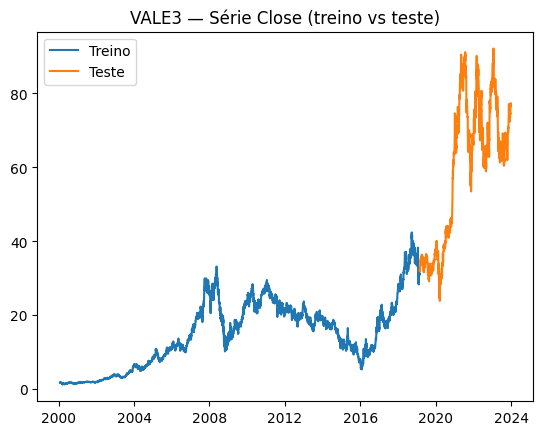

# PETR4 — EDA

### treino.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,1,2000-01-24,1.274788,1.347845,-1,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995,1.351823,1.356514,1.370341,1.450586
1,2,2000-01-25,1.274788,1.340540,-1,1.274788,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995,1.351823,1.356514,1.370341
2,3,2000-01-26,1.290096,1.335495,-1,1.274788,1.274788,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995,1.351823,1.356514
3,4,2000-01-27,1.280960,1.330042,-1,1.290096,1.274788,1.274788,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995,1.351823
4,5,2000-01-28,1.280960,1.325134,-1,1.280960,1.290096,1.274788,1.274788,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995


**Colunas (treino):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

### teste.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,4809,2019-02-26,9.467936,9.376527,1,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673,9.289832
1,4810,2019-02-27,9.646040,9.403478,1,9.467936,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673
2,4811,2019-02-28,9.638913,9.427022,1,9.646040,9.467936,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191
3,4812,2019-03-01,9.510681,9.435388,1,9.638913,9.646040,9.467936,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439
4,4813,2019-03-06,9.532050,9.445054,1,9.510681,9.638913,9.646040,9.467936,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140


**Colunas (teste):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

- **Tamanho treino/teste:** (4808, 20) / (1203, 20)  
- **Período treino:** 2000-01-24 00:00:00 → 2019-02-25 00:00:00  
- **Período teste:** 2019-02-26 00:00:00 → 2023-12-28 00:00:00

### Distribuição de rótulos

**Treino:** {-1: 2654, 1: 2154}  
**Treino (%):** {-1: 55.2, 1: 44.8}

**Teste:** {-1: 581, 1: 622}  
**Teste (%):** {-1: 48.3, 1: 51.7}

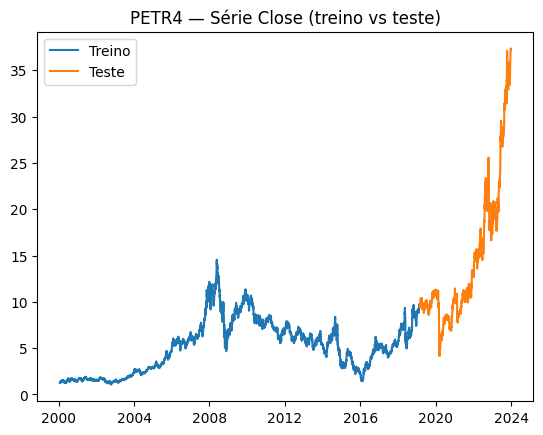

# BBAS3 — EDA

### treino.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,1,2000-01-24,1.062769,1.071645,-1,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940,1.023457,1.074564
1,2,2000-01-26,1.087668,1.073247,-1,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940,1.023457
2,3,2000-01-27,1.064080,1.072330,-1,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940
3,4,2000-01-28,1.036561,1.068753,-1,1.064080,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355
4,5,2000-01-31,1.035250,1.065403,-1,1.036561,1.064080,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767


**Colunas (treino):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

### teste.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,4736,2019-03-26,36.386158,37.917648,-1,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129
1,4737,2019-03-27,34.371300,37.563014,-1,36.386158,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866
2,4738,2019-03-28,35.571316,37.363844,-1,34.371300,36.386158,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150
3,4739,2019-03-29,36.089863,37.236446,-1,35.571316,34.371300,36.386158,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489
4,4740,2019-04-01,36.445412,37.157342,-1,36.089863,35.571316,34.371300,36.386158,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267


**Colunas (teste):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

- **Tamanho treino/teste:** (4735, 20) / (1185, 20)  
- **Período treino:** 2000-01-24 00:00:00 → 2019-03-25 00:00:00  
- **Período teste:** 2019-03-26 00:00:00 → 2023-12-28 00:00:00

### Distribuição de rótulos

**Treino:** {-1: 2602, 1: 2133}  
**Treino (%):** {-1: 54.95, 1: 45.05}

**Teste:** {-1: 689, 1: 496}  
**Teste (%):** {-1: 58.14, 1: 41.86}

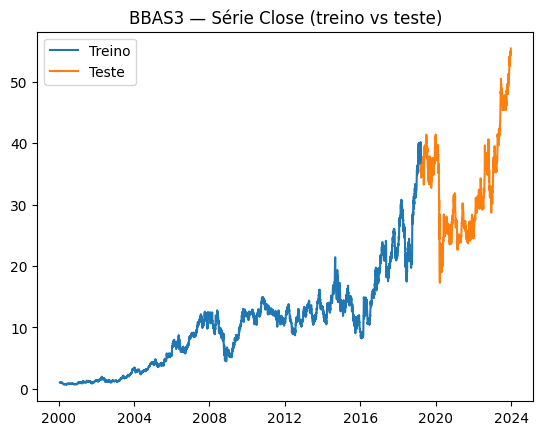

# CSNA3 — EDA

### treino.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,1,2000-01-24,1.409986,1.588954,-1,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271,1.773139,1.682777,1.658908
1,2,2000-01-26,1.398052,1.569864,-1,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271,1.773139,1.682777
2,3,2000-01-27,1.375888,1.550466,-1,1.398052,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271,1.773139
3,4,2000-01-28,1.363953,1.531815,-1,1.375888,1.398052,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271
4,5,2000-01-31,1.329854,1.511619,-1,1.363953,1.375888,1.398052,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336


**Colunas (treino):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

### teste.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,4744,2019-03-25,9.917939,9.592937,1,9.957878,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488
1,4745,2019-03-26,10.543634,9.688007,1,9.917939,9.957878,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026
2,4746,2019-03-27,10.004474,9.719654,1,10.543634,9.917939,9.957878,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350
3,4747,2019-03-28,10.437135,9.791402,1,10.004474,10.543634,9.917939,9.957878,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440
4,4748,2019-03-29,10.816545,9.893916,1,10.437135,10.004474,10.543634,9.917939,9.957878,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118


**Colunas (teste):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

- **Tamanho treino/teste:** (4743, 20) / (1186, 20)  
- **Período treino:** 2000-01-24 00:00:00 → 2019-03-22 00:00:00  
- **Período teste:** 2019-03-25 00:00:00 → 2023-12-28 00:00:00

### Distribuição de rótulos

**Treino:** {-1: 2655, 1: 2088}  
**Treino (%):** {-1: 55.98, 1: 44.02}

**Teste:** {-1: 688, 1: 498}  
**Teste (%):** {-1: 58.01, 1: 41.99}

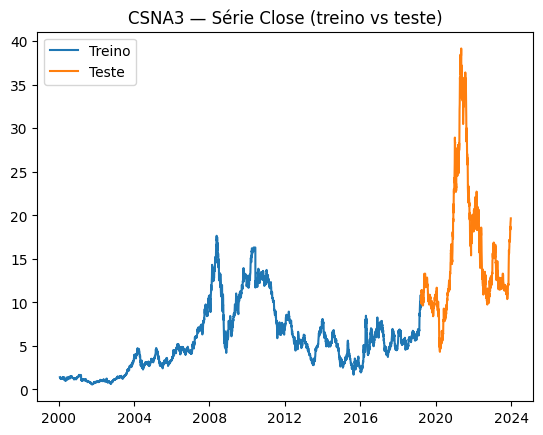

In [3]:

for ticker in CONFIG['FILES'].keys():
    df_tr, df_te = load_pair(ticker)
    parse_dates_inplace(df_tr)
    parse_dates_inplace(df_te)

    display(Markdown(f"# {ticker} — EDA"))
    display(Markdown("### treino.csv — head()"))
    display(df_tr.head())
    display(Markdown(f"**Colunas (treino):** {list(df_tr.columns)}"))
    display(Markdown("### teste.csv — head()"))
    display(df_te.head())
    display(Markdown(f"**Colunas (teste):** {list(df_te.columns)}"))

    dc = CONFIG['DATE_COL']
    tr_dates = (df_tr[dc].min(), df_tr[dc].max()) if dc in df_tr.columns else (None, None)
    te_dates = (df_te[dc].min(), df_te[dc].max()) if dc in df_te.columns else (None, None)
    display(Markdown(
        f"- **Tamanho treino/teste:** {df_tr.shape} / {df_te.shape}  \n"
        f"- **Período treino:** {tr_dates[0]} → {tr_dates[1]}  \n"
        f"- **Período teste:** {te_dates[0]} → {te_dates[1]}"
    ))

    ytr = df_tr[CONFIG['LABEL_COL']].astype(int)
    yte = df_te[CONFIG['LABEL_COL']].astype(int)
    ctr = ytr.value_counts().sort_index(); cte = yte.value_counts().sort_index()
    ptr = (ctr / ctr.sum() * 100).round(2); pte = (cte / cte.sum() * 100).round(2)
    display(Markdown("### Distribuição de rótulos"))
    display(Markdown(f"**Treino:** {ctr.to_dict()}  \n**Treino (%):** {ptr.to_dict()}"))
    display(Markdown(f"**Teste:** {cte.to_dict()}  \n**Teste (%):** {pte.to_dict()}"))

    cc = CONFIG['CLOSE_COL']
    if cc in df_tr.columns and cc in df_te.columns:
        fig, ax = plt.subplots()
        if dc in df_tr.columns:
            ax.plot(df_tr[dc], df_tr[cc], label="Treino")
        else:
            ax.plot(df_tr[cc].values, label="Treino")
        if dc in df_te.columns:
            ax.plot(df_te[dc], df_te[cc], label="Teste")
        else:
            ax.plot(df_te[cc].values, label="Teste")
        ax.set_title(f"{ticker} — Série Close (treino vs teste)")
        ax.legend()
        plt.show()



## Modelagem — MLP, CNN1D e LSTM


In [4]:

def build_mlp():
    model = keras.Sequential([
        layers.Input(shape=(CONFIG['WINDOW'],)),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="tanh")
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
    return model

def build_cnn1d():
    model = keras.Sequential([
        layers.Input(shape=(CONFIG['WINDOW'], 1)),
        layers.Conv1D(32, kernel_size=3, padding="causal", activation="relu"),
        layers.Conv1D(32, kernel_size=5, padding="causal", activation="relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="tanh")
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
    return model

def build_lstm():
    model = keras.Sequential([
        layers.Input(shape=(CONFIG['WINDOW'], 1)),
        layers.LSTM(32, return_sequences=False),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="tanh")
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
    return model

def tanh_to_pm1(pred):
    return np.where(pred.ravel() >= 0, 1, -1)

def eval_model(model, Xtr, ytr, Xte, yte, epochs=25, batch_size=64, verbose=0):
    hist = model.fit(Xtr, ytr, epochs=epochs, batch_size=batch_size, validation_data=(Xte, yte), verbose=verbose)
    yhat = model.predict(Xte, verbose=0)
    ypred = tanh_to_pm1(yhat)
    acc = accuracy_score(yte, ypred)
    cm  = confusion_matrix(yte, ypred, labels=[-1, 1])
    pr, rc, f1, _ = precision_recall_fscore_support(yte, ypred, labels=[1], average=None)
    return {"accuracy": acc, "precision_+1": pr[0], "recall_+1": rc[0], "f1_+1": f1[0], "cm": cm, "history": hist.history, "ypred": ypred}


In [5]:

# ================== EXECUÇÃO POR TICKER ==================
def run_all_models():
    all_results = []
    cms = {}
    ypred_store = {}  
    ytrue_store = {}  
    for ticker in CONFIG['FILES'].keys():
        df_tr, df_te = load_pair(ticker)
        Xtr, ytr = prepare_xy(df_tr); Xte, yte = prepare_xy(df_te)
        ytrue_store[ticker] = yte
        Xtr_s, Xte_s, Xtr_seq, Xte_seq = scale_and_reshape(Xtr, Xte)

        # MLP
        mlp = build_mlp()
        r_mlp = eval_model(mlp, Xtr_s, ytr, Xte_s, yte)
        all_results.append({"ticker": ticker, "model": "MLP", **{k:v for k,v in r_mlp.items() if k not in ('cm','history','ypred')}})
        cms[(ticker,"MLP")] = r_mlp["cm"]; ypred_store[(ticker,"MLP")] = r_mlp["ypred"]

        # CNN1D
        cnn = build_cnn1d()
        r_cnn = eval_model(cnn, Xtr_seq, ytr, Xte_seq, yte)
        all_results.append({"ticker": ticker, "model": "CNN1D", **{k:v for k,v in r_cnn.items() if k not in ('cm','history','ypred')}})
        cms[(ticker,"CNN1D")] = r_cnn["cm"]; ypred_store[(ticker,"CNN1D")] = r_cnn["ypred"]

        # LSTM
        lstm = build_lstm()
        r_lstm = eval_model(lstm, Xtr_seq, ytr, Xte_seq, yte)
        all_results.append({"ticker": ticker, "model": "LSTM", **{k:v for k,v in r_lstm.items() if k not in ('cm','history','ypred')}})
        cms[(ticker,"LSTM")] = r_lstm["cm"]; ypred_store[(ticker,"LSTM")] = r_lstm["ypred"]
    return all_results, cms, ypred_store, ytrue_store

all_results, cms, ypred_store, ytrue_store = run_all_models()

tbl = pd.DataFrame(all_results, columns=["ticker","model","accuracy","precision_+1","recall_+1","f1_+1"]) 
tbl.sort_values(["ticker","f1_+1","accuracy"], ascending=[True, False, False], inplace=True)
display(Markdown("### **Consolidado — Métricas por ativo/modelo**"))
display(tbl)

# ====== Métricas detalhadas por ativo/modelo ======
for (ticker, model), ypred in ypred_store.items():
    y_true = ytrue_store[ticker]
    acc = accuracy_score(y_true, ypred)
    cm = confusion_matrix(y_true, ypred, labels=[-1, 1])
    pre, rec, f1, sup = precision_recall_fscore_support(y_true, ypred, labels=[-1, 1], zero_division=0)
    report = classification_report(y_true, ypred, target_names=["SELL(-1)", "BUY(+1)"], digits=4, zero_division=0)

    display(Markdown(f"## {ticker} — {model}"))
    display(Markdown(f"**Acurácia (teste):** {acc:.4f}"))

    cm_df = pd.DataFrame(cm, index=["Verdade -1","Verdade +1"], columns=["Pred -1","Pred +1"]) 
    display(Markdown("**Matriz de confusão:**")); display(cm_df)

    pr_df = pd.DataFrame({
        "Classe": ["-1","+1"],
        "Precision": [pre[0], pre[1]],
        "Recall": [rec[0], rec[1]],
        "F1": [f1[0], f1[1]],
        "Suporte": [sup[0], sup[1]],
    })
    display(Markdown("**Precision/Recall/F1:**")); display(pr_df)

    display(Markdown("**Classification report (texto):**"))
    print(report)


### **Consolidado — Métricas por ativo/modelo**

,ticker,model,accuracy,precision_+1,recall_+1,f1_+1
7,BBAS3,CNN1D,0.890295,0.845283,0.903226,0.873294
6,BBAS3,MLP,0.832911,0.723054,0.973790,0.829897
8,BBAS3,LSTM,0.656540,0.567119,0.758065,0.648835
9,CSNA3,MLP,0.880270,0.797659,0.957831,0.870438
10,CSNA3,CNN1D,0.846543,0.793680,0.857430,0.824324
11,CSNA3,LSTM,0.775717,0.738683,0.720884,0.729675
3,PETR4,MLP,0.862012,0.844411,0.898714,0.870717
4,PETR4,CNN1D,0.852037,0.847962,0.869775,0.858730
5,PETR4,LSTM,0.609310,0.637184,0.567524,0.600340
0,VALE3,MLP,0.857024,0.789757,0.973422,0.872024


## VALE3 — MLP

**Acurácia (teste):** 0.8570

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,445,156
Verdade +1,16,586


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.965293,0.740433,0.838041,601
1,+1,0.789757,0.973422,0.872024,602


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.9653    0.7404    0.8380       601
     BUY(+1)     0.7898    0.9734    0.8720       602

    accuracy                         0.8570      1203
   macro avg     0.8775    0.8569    0.8550      1203
weighted avg     0.8775    0.8570    0.8550      1203



## VALE3 — CNN1D

**Acurácia (teste):** 0.8587

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,481,120
Verdade +1,50,552


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.905838,0.800333,0.849823,601
1,+1,0.821429,0.916944,0.866562,602


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.9058    0.8003    0.8498       601
     BUY(+1)     0.8214    0.9169    0.8666       602

    accuracy                         0.8587      1203
   macro avg     0.8636    0.8586    0.8582      1203
weighted avg     0.8636    0.8587    0.8582      1203



## VALE3 — LSTM

**Acurácia (teste):** 0.6002

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,543,58
Verdade +1,423,179


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.562112,0.903494,0.693044,601
1,+1,0.755274,0.297342,0.426698,602


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.5621    0.9035    0.6930       601
     BUY(+1)     0.7553    0.2973    0.4267       602

    accuracy                         0.6002      1203
   macro avg     0.6587    0.6004    0.5599      1203
weighted avg     0.6588    0.6002    0.5598      1203



## PETR4 — MLP

**Acurácia (teste):** 0.8620

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,478,103
Verdade +1,63,559


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.883549,0.822719,0.852050,581
1,+1,0.844411,0.898714,0.870717,622


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.8835    0.8227    0.8520       581
     BUY(+1)     0.8444    0.8987    0.8707       622

    accuracy                         0.8620      1203
   macro avg     0.8640    0.8607    0.8614      1203
weighted avg     0.8633    0.8620    0.8617      1203



## PETR4 — CNN1D

**Acurácia (teste):** 0.8520

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,484,97
Verdade +1,81,541


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.856637,0.833046,0.844677,581
1,+1,0.847962,0.869775,0.858730,622


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.8566    0.8330    0.8447       581
     BUY(+1)     0.8480    0.8698    0.8587       622

    accuracy                         0.8520      1203
   macro avg     0.8523    0.8514    0.8517      1203
weighted avg     0.8522    0.8520    0.8519      1203



## PETR4 — LSTM

**Acurácia (teste):** 0.6093

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,380,201
Verdade +1,269,353


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.585516,0.654045,0.617886,581
1,+1,0.637184,0.567524,0.600340,622


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.5855    0.6540    0.6179       581
     BUY(+1)     0.6372    0.5675    0.6003       622

    accuracy                         0.6093      1203
   macro avg     0.6114    0.6108    0.6091      1203
weighted avg     0.6122    0.6093    0.6088      1203



## BBAS3 — MLP

**Acurácia (teste):** 0.8329

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,504,185
Verdade +1,13,483


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.974855,0.731495,0.835821,689
1,+1,0.723054,0.973790,0.829897,496


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.9749    0.7315    0.8358       689
     BUY(+1)     0.7231    0.9738    0.8299       496

    accuracy                         0.8329      1185
   macro avg     0.8490    0.8526    0.8329      1185
weighted avg     0.8695    0.8329    0.8333      1185



## BBAS3 — CNN1D

**Acurácia (teste):** 0.8903

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,607,82
Verdade +1,48,448


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.926718,0.880987,0.903274,689
1,+1,0.845283,0.903226,0.873294,496


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.9267    0.8810    0.9033       689
     BUY(+1)     0.8453    0.9032    0.8733       496

    accuracy                         0.8903      1185
   macro avg     0.8860    0.8921    0.8883      1185
weighted avg     0.8926    0.8903    0.8907      1185



## BBAS3 — LSTM

**Acurácia (teste):** 0.6565

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,402,287
Verdade +1,120,376


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.770115,0.583454,0.663914,689
1,+1,0.567119,0.758065,0.648835,496


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.7701    0.5835    0.6639       689
     BUY(+1)     0.5671    0.7581    0.6488       496

    accuracy                         0.6565      1185
   macro avg     0.6686    0.6708    0.6564      1185
weighted avg     0.6851    0.6565    0.6576      1185



## CSNA3 — MLP

**Acurácia (teste):** 0.8803

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,567,121
Verdade +1,21,477


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.964286,0.824128,0.888715,688
1,+1,0.797659,0.957831,0.870438,498


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.9643    0.8241    0.8887       688
     BUY(+1)     0.7977    0.9578    0.8704       498

    accuracy                         0.8803      1186
   macro avg     0.8810    0.8910    0.8796      1186
weighted avg     0.8943    0.8803    0.8810      1186



## CSNA3 — CNN1D

**Acurácia (teste):** 0.8465

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,577,111
Verdade +1,71,427


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.890432,0.838663,0.863772,688
1,+1,0.793680,0.857430,0.824324,498


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.8904    0.8387    0.8638       688
     BUY(+1)     0.7937    0.8574    0.8243       498

    accuracy                         0.8465      1186
   macro avg     0.8421    0.8480    0.8440      1186
weighted avg     0.8498    0.8465    0.8472      1186



## CSNA3 — LSTM

**Acurácia (teste):** 0.7757

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,561,127
Verdade +1,139,359


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.801429,0.815407,0.808357,688
1,+1,0.738683,0.720884,0.729675,498


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.8014    0.8154    0.8084       688
     BUY(+1)     0.7387    0.7209    0.7297       498

    accuracy                         0.7757      1186
   macro avg     0.7701    0.7681    0.7690      1186
weighted avg     0.7751    0.7757    0.7753      1186



In [6]:
def highlight_max_custom(s):
    is_max = s == s.max()
    return ['background-color: #2ecc71; color: black; font-weight: bold;' if v else '' for v in is_max]

pivot = tbl.pivot(index="ticker", columns="model", values="accuracy")
display(Markdown("### Destaque por linha (maior accuracy)"))
display(pivot.style.apply(highlight_max_custom, axis=1))

### Destaque por linha (maior accuracy)

model,CNN1D,LSTM,MLP
ticker,,,
BBAS3,0.890295,0.656540,0.832911
CSNA3,0.846543,0.775717,0.880270
PETR4,0.852037,0.609310,0.862012
VALE3,0.858687,0.600166,0.857024



## Backtest 
Compara **Buy & Hold** vs. a **estratégia** 


### **VALE3**

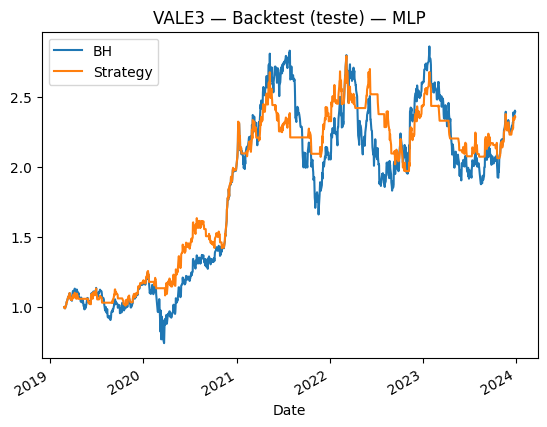

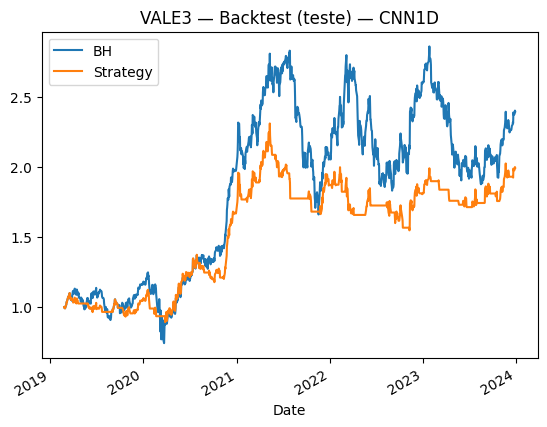

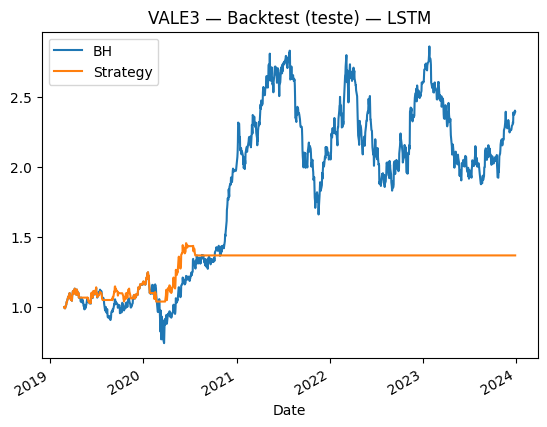

### **PETR4**

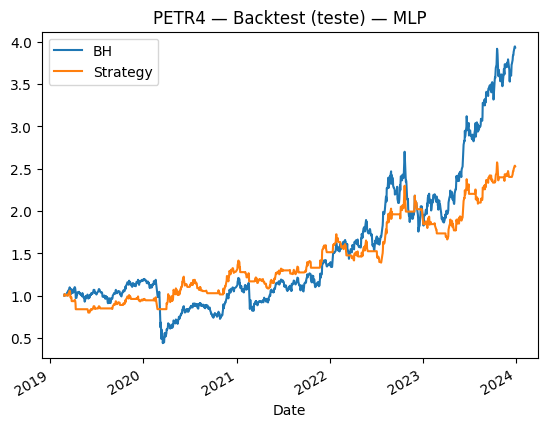

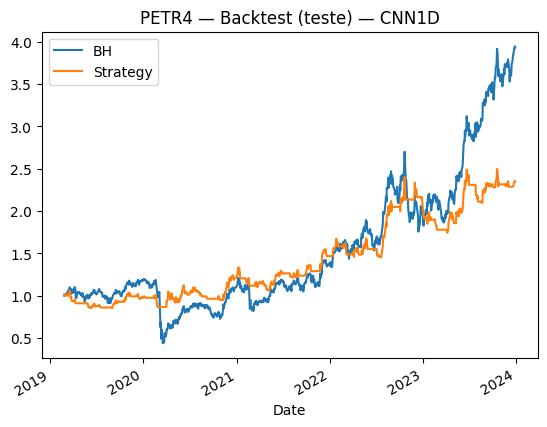

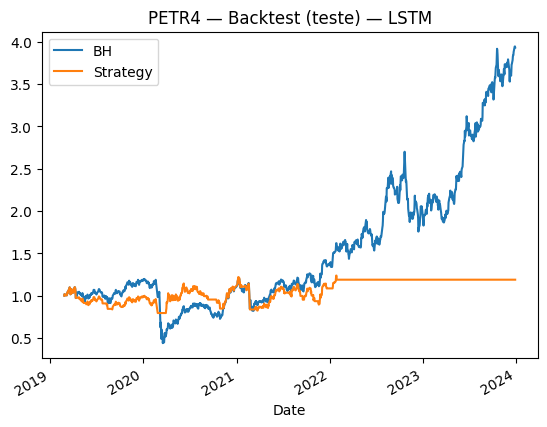

### **BBAS3**

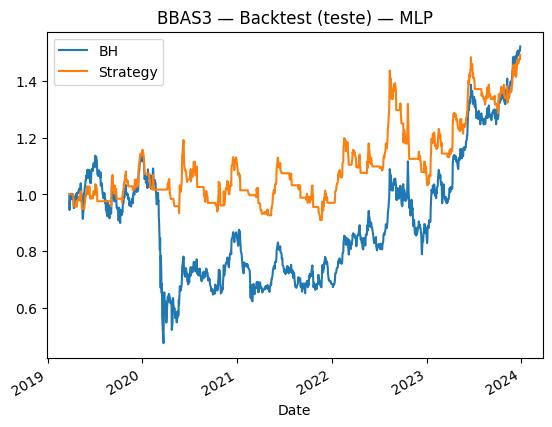

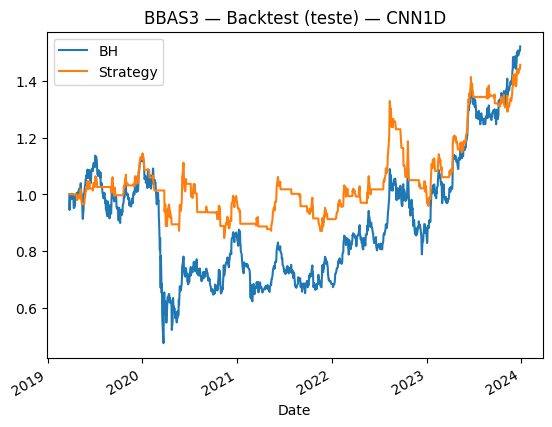

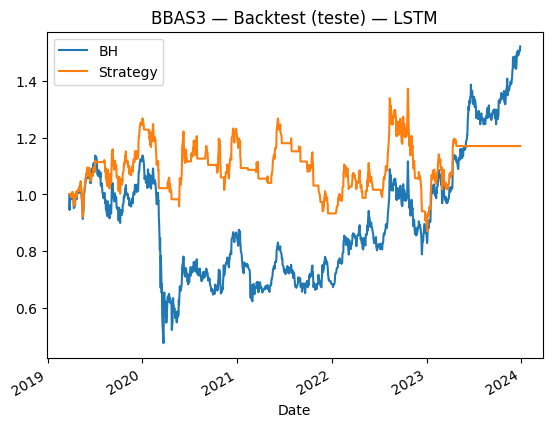

### **CSNA3**

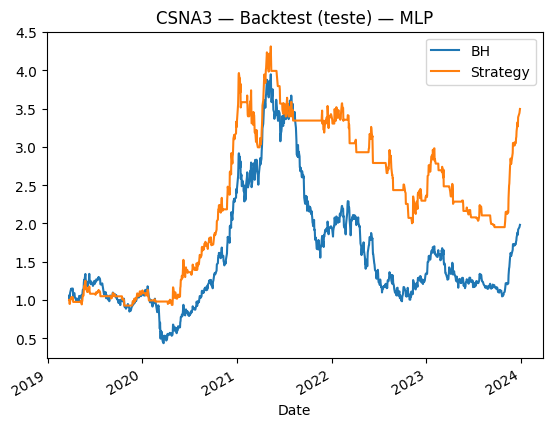

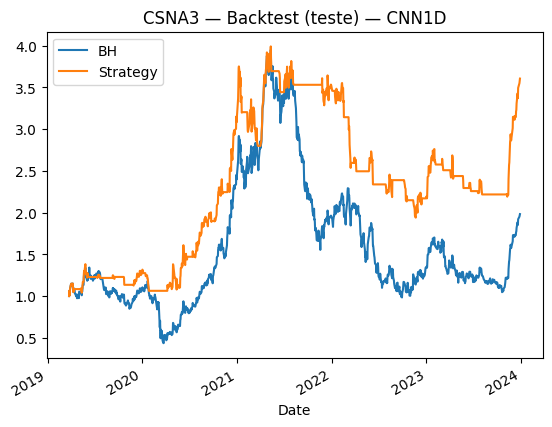

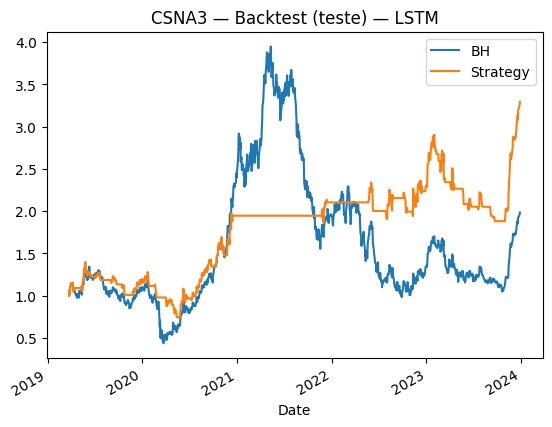

In [7]:

def backtest_equity_curve(df_test: pd.DataFrame, ypred_pm1: np.ndarray, date_col: str, close_col: str):
    # posição long/flat
    pos = (ypred_pm1 == 1).astype(int)
    close = df_test[close_col].astype(float).values
    ret = pd.Series(close).pct_change().fillna(0).values

    strat_eq = (1 + ret * pos).cumprod()
    bh_eq = (1 + ret).cumprod()

    if date_col in df_test.columns:
        idx = pd.to_datetime(df_test[date_col], errors='coerce')
    else:
        idx = pd.RangeIndex(len(df_test))

    return pd.DataFrame({"BH": bh_eq, "Strategy": strat_eq}, index=idx)

for ticker in CONFIG['FILES'].keys():
    display(Markdown(f"### **{ticker}**"))
    _, df_te = load_pair(ticker)
    for model in ["MLP","CNN1D","LSTM"]:
        eq = backtest_equity_curve(df_te, ypred_store[(ticker, model)], CONFIG['DATE_COL'], CONFIG['CLOSE_COL'])
        fig, ax = plt.subplots()
        eq.plot(ax=ax)
        ax.set_title(f"{ticker} — Backtest (teste) — {model}")
        plt.show()


# Análise das imagens  
Teste inicial com CSNA3

In [8]:
# ========= CNN 2D (comprar vs vender) =========
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)


TICKER = "CSNA3" 
ROOT   = Path("bases") / f"{TICKER}SA" / "imagens"
TRAIN_DIR, TEST_DIR = ROOT/"treino", ROOT/"teste"

IMG_SIZE = (128, 128)
BATCH    = 32
AUTOTUNE = tf.data.AUTOTUNE

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH, label_mode='binary', seed=SEED)
ds_test  = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,  image_size=IMG_SIZE, batch_size=BATCH, label_mode='binary', seed=SEED)

class_names = ds_train.class_names  # ['comprar','vender']
normalizer  = keras.Sequential([layers.Rescaling(1/255.)])

ds_train = ds_train.map(lambda x,y: (normalizer(x), y), num_parallel_calls=AUTOTUNE).cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
ds_test  = ds_test.map(lambda x,y: (normalizer(x), y),  num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

print("Classes:", class_names)


Found 4743 files belonging to 2 classes.
Found 1186 files belonging to 2 classes.
Classes: ['comprar', 'vender']


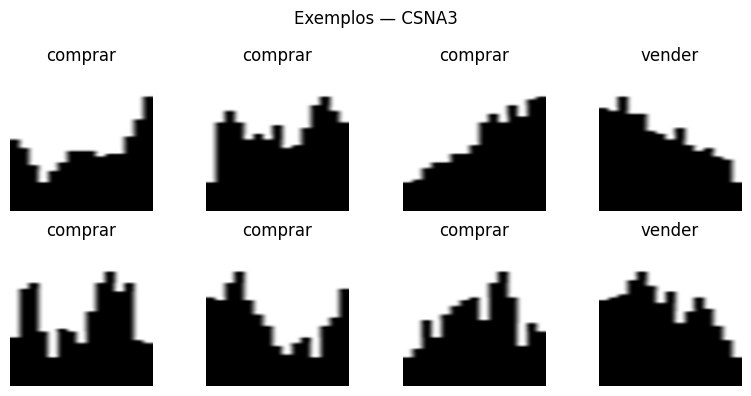

In [9]:

plt.figure(figsize=(8,4))
for i,(x,y) in enumerate(ds_train.unbatch().take(8)):
    plt.subplot(2,4,i+1)
    plt.imshow(x.numpy())
    plt.axis("off")
    plt.title(class_names[int(y.numpy())])
plt.suptitle(f"Exemplos — {TICKER}")
plt.tight_layout(); plt.show()


In [10]:
# --- CNN 2D  ---
model = keras.Sequential([
    layers.Input(shape=(*IMG_SIZE,3)),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128,3, padding='same', activation='relu'),
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid')   # binário: comprar(0)/vender(1)
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])

model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 33s 201ms/step - accuracy: 0.6608 - loss: 0.6089 - precision: 0.6493 - recall: 0.8565 - val_accuracy: 0.8474 - val_loss: 0.3419 - val_precision: 0.8221 - val_recall: 0.9404
Epoch 2/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 29s 194ms/step - accuracy: 0.8484 - loss: 0.3445 - precision: 0.8656 - recall: 0.8633 - val_accuracy: 0.8406 - val_loss: 0.3563 - val_precision: 0.9561 - val_recall: 0.7602
Epoch 3/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 30s 198ms/step - accuracy: 0.8697 - loss: 0.2957 - precision: 0.8895 - recall: 0.8761 - val_accuracy: 0.8676 - val_loss: 0.2969 - val_precision: 0.9374 - val_recall: 0.8270
Epoch 4/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 29s 193ms/step - accuracy: 0.8767 - loss: 0.2795 - precision: 0.8920 - recall: 0.8870 - val_accuracy: 0.8702 - val_loss: 0.2928 - val_precision: 0.9450 - val_recall: 0.8241
Epoch 5/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 29s 195ms/step - accuracy: 0.8832 - loss: 0.2753 - precision: 0.8981 - recall: 0.8927 - val_accuracy: 0.8718

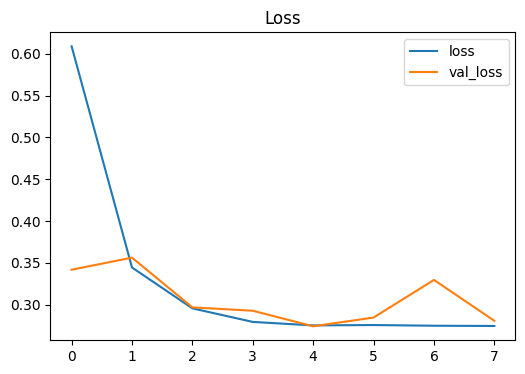

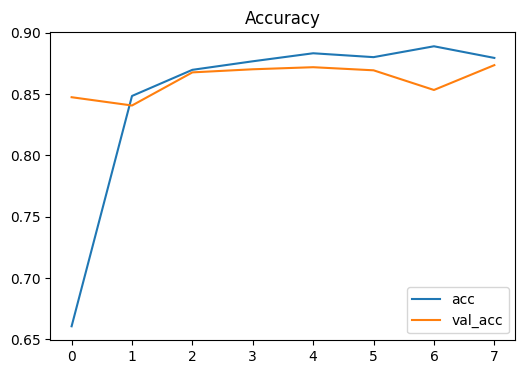

In [11]:
# --- treino básico com early stopping ---
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]
history = model.fit(ds_train, validation_data=ds_test, epochs=15, callbacks=callbacks, verbose=1)

# curvas
h = history.history
plt.figure(figsize=(6,4)); plt.plot(h['loss'], label='loss'); plt.plot(h['val_loss'], label='val_loss'); plt.legend(); plt.title('Loss'); plt.show()
plt.figure(figsize=(6,4)); plt.plot(h['accuracy'], label='acc'); plt.plot(h['val_accuracy'], label='val_acc'); plt.legend(); plt.title('Accuracy'); plt.show()


Teste — Acc: 0.872  Precision: 0.920  Recall: 0.853  F1: 0.885

Relatório por classe (0 = comprar, 1 = vender):
              precision    recall  f1-score   support

     comprar       0.82      0.90      0.85       498
      vender       0.92      0.85      0.89       688

    accuracy                           0.87      1186
   macro avg       0.87      0.88      0.87      1186
weighted avg       0.88      0.87      0.87      1186



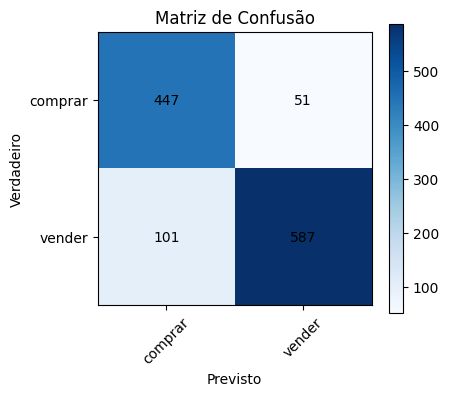

In [12]:
# --- avaliação no teste ---
# rótulos verdadeiros e probabilidades
y_true = np.concatenate([y.numpy().ravel() for _, y in ds_test])
y_prob = np.concatenate([model.predict(x, verbose=0).ravel() for x,_ in ds_test])
y_pred = (y_prob >= 0.5).astype(int)  # limiar simples de 0.5

acc = (y_pred == y_true).mean()
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
cm = confusion_matrix(y_true, y_pred, labels=[0,1])

print(f"Teste — Acc: {acc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}")
print("\nRelatório por classe (0 = comprar, 1 = vender):")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# matriz de confusão
plt.figure(figsize=(4.6,4))
plt.imshow(cm, cmap='Blues'); plt.title('Matriz de Confusão'); plt.colorbar()
ticks = np.arange(len(class_names)); plt.xticks(ticks, class_names, rotation=45); plt.yticks(ticks, class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='black')
plt.ylabel('Verdadeiro'); plt.xlabel('Previsto'); plt.tight_layout(); plt.show()


## Após primeiro teste, executando para as 4 ações

In [13]:
EPOCHS   = 15
VAL_SPLIT= 0.15

TICKERS = ["VALE3", "PETR4", "BBAS3", "CSNA3"]


def image_root_for(ticker: str) -> Path:
    return Path("bases") / f"{ticker}SA" / "imagens"


In [14]:
# ==== FUNÇÕES DE DADOS ====
def load_image_datasets(root: Path, img_size=IMG_SIZE, batch=BATCH, seed=SEED, val_split=VAL_SPLIT):
    train_dir = root/"treino"
    test_dir  = root/"teste"
    if not train_dir.exists() or not test_dir.exists():
        return None

    # treino + validação a partir do diretório de treino
    ds_train = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir, image_size=img_size, batch_size=batch,
        label_mode='binary', seed=seed, validation_split=val_split, subset='training'
    )
    ds_val = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir, image_size=img_size, batch_size=batch,
        label_mode='binary', seed=seed, validation_split=val_split, subset='validation'
    )
    ds_test = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,  image_size=img_size, batch_size=batch,
        label_mode='binary', seed=seed
    )

    class_names = ds_train.class_names  # ['comprar','vender']
    norm = keras.Sequential([layers.Rescaling(1/255.)])
    ds_train = ds_train.map(lambda x,y: (norm(x), y), num_parallel_calls=AUTOTUNE).cache().shuffle(1000, seed=seed).prefetch(AUTOTUNE)
    ds_val   = ds_val  .map(lambda x,y: (norm(x), y), num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
    ds_test  = ds_test .map(lambda x,y: (norm(x), y), num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
    return ds_train, ds_val, ds_test, class_names

def count_by_class(split_dir: Path, classes):
    exts = {".png",".jpg",".jpeg",".bmp",".gif"}
    return {c: sum(1 for f in (split_dir/c).rglob("*") if f.suffix.lower() in exts) for c in classes}


In [15]:
# ==== MODELO ====
def build_cnn2d(img_size=IMG_SIZE):
    model = keras.Sequential([
        layers.Input(shape=(*img_size, 3)),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128,3, padding='same', activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])
    return model


In [16]:
# ==== TREINO + AVALIAÇÃO ====
def train_and_eval_for_ticker(ticker: str):
    root = image_root_for(ticker)
    ds = load_image_datasets(root)
    if ds is None:
        return {'ticker': ticker, 'status': 'sem_imagens'}

    ds_train, ds_val, ds_test, class_names = ds
    # pesos de classe (opcional, ajuda se desbalanceado)
    train_counts = count_by_class(root/"treino", class_names)
    tot = sum(train_counts.values())
    class_weight = {0: tot/(2*train_counts[class_names[0]]) if train_counts[class_names[0]] else 1.0,
                    1: tot/(2*train_counts[class_names[1]]) if train_counts[class_names[1]] else 1.0}

    model = build_cnn2d()
    callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]
    history = model.fit(ds_train, validation_data=ds_val, epochs=EPOCHS, callbacks=callbacks, class_weight=class_weight, verbose=0)

    # avaliação no TESTE
    y_true = np.concatenate([y.numpy().ravel() for _, y in ds_test])
    y_prob = np.concatenate([model.predict(x, verbose=0).ravel() for x,_ in ds_test])
    y_pred = (y_prob >= 0.5).astype(int)

    acc = (y_pred == y_true).mean()
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])

    # relatório por classe (string simples para o notebook)
    cls_report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)

    return {
        'ticker': ticker,
        'status': 'ok',
        'class_names': class_names,
        'train_counts': train_counts,
        'metrics': {'acc': float(acc), 'precision': float(prec), 'recall': float(rec), 'f1': float(f1)},
        'cm': cm,
        'report': cls_report,
        'history': history.history,
        'y_prob_test': y_prob,    
        'y_pred_test': y_pred     
    }


=== VALE3 ===
Found 4808 files belonging to 2 classes.
Using 4087 files for training.
Found 4808 files belonging to 2 classes.
Using 721 files for validation.
Found 1203 files belonging to 2 classes.
Teste — Acc: 0.872  Precision: 0.862  Recall: 0.885  F1: 0.874
              precision    recall  f1-score   support

     comprar       0.88      0.86      0.87       602
      vender       0.86      0.89      0.87       601

    accuracy                           0.87      1203
   macro avg       0.87      0.87      0.87      1203
weighted avg       0.87      0.87      0.87      1203



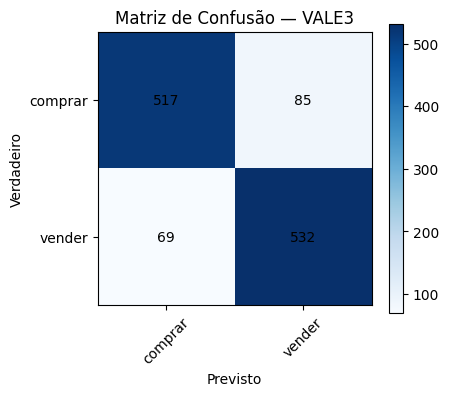

=== PETR4 ===
Found 4808 files belonging to 2 classes.
Using 4087 files for training.
Found 4808 files belonging to 2 classes.
Using 721 files for validation.
Found 1203 files belonging to 2 classes.
Teste — Acc: 0.868  Precision: 0.868  Recall: 0.857  F1: 0.862
              precision    recall  f1-score   support

     comprar       0.87      0.88      0.87       622
      vender       0.87      0.86      0.86       581

    accuracy                           0.87      1203
   macro avg       0.87      0.87      0.87      1203
weighted avg       0.87      0.87      0.87      1203



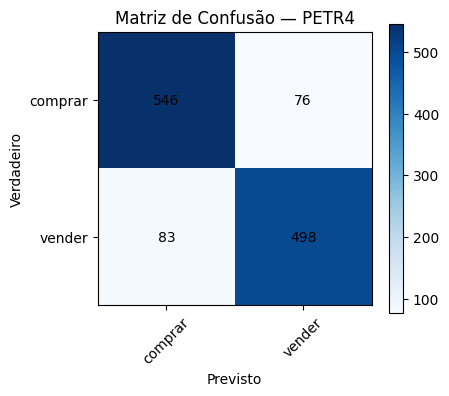

=== BBAS3 ===
Found 4735 files belonging to 2 classes.
Using 4025 files for training.
Found 4735 files belonging to 2 classes.
Using 710 files for validation.
Found 1185 files belonging to 2 classes.
Teste — Acc: 0.889  Precision: 0.912  Recall: 0.897  F1: 0.904
              precision    recall  f1-score   support

     comprar       0.86      0.88      0.87       496
      vender       0.91      0.90      0.90       689

    accuracy                           0.89      1185
   macro avg       0.89      0.89      0.89      1185
weighted avg       0.89      0.89      0.89      1185



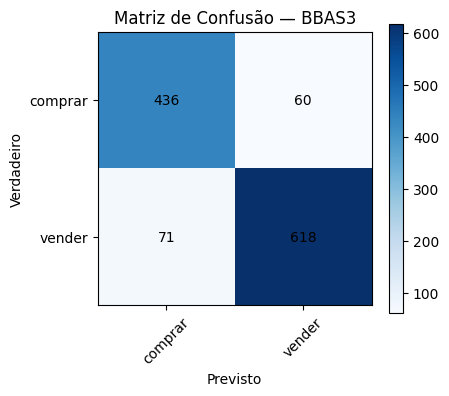

=== CSNA3 ===
Found 4743 files belonging to 2 classes.
Using 4032 files for training.
Found 4743 files belonging to 2 classes.
Using 711 files for validation.
Found 1186 files belonging to 2 classes.
Teste — Acc: 0.875  Precision: 0.899  Recall: 0.884  F1: 0.891
              precision    recall  f1-score   support

     comprar       0.84      0.86      0.85       498
      vender       0.90      0.88      0.89       688

    accuracy                           0.88      1186
   macro avg       0.87      0.87      0.87      1186
weighted avg       0.88      0.88      0.88      1186



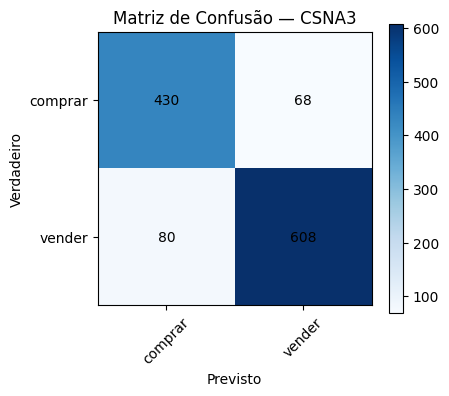

In [17]:
# ==== LOOP 
if 'results' not in globals():
    results = []
for t in TICKERS:
    print(f"=== {t} ===")
    out = train_and_eval_for_ticker(t)
    if out['status'] == 'ok':
        if 'ypred_store' not in globals():
            ypred_store = {}
        ypred_store[(t, 'CNN2D')] = (np.asarray(out['y_pred_test']).astype(int) == 1).astype(int)
        m = out['metrics']
        print(f"Teste — Acc: {m['acc']:.3f}  Precision: {m['precision']:.3f}  Recall: {m['recall']:.3f}  F1: {m['f1']:.3f}")
        print(out['report'])
        # plot da matriz de confusão
        cm = out['cm']; classes = out['class_names']
        plt.figure(figsize=(4.6,4))
        plt.imshow(cm, cmap='Blues'); plt.title(f'Matriz de Confusão — {t}'); plt.colorbar()
        ticks = np.arange(len(classes)); plt.xticks(ticks, classes, rotation=45); plt.yticks(ticks, classes)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, cm[i,j], ha='center', va='center', color='black')
        plt.ylabel('Verdadeiro'); plt.xlabel('Previsto'); plt.tight_layout(); plt.show()

        results.append({'Ticker': t, 'Acc': m['acc'], 'Precision': m['precision'], 'Recall': m['recall'], 'F1': m['f1']})
    else:
        print("Pastas de imagens não encontradas — pulando.")
        results.append({'Ticker': t, 'Acc': np.nan, 'Precision': np.nan, 'Recall': np.nan, 'F1': np.nan})




In [18]:
df_res = pd.DataFrame(results).set_index('Ticker').round(3)
df_res

,Acc,Precision,Recall,F1
Ticker,,,,
VALE3,0.872,0.862,0.885,0.874
PETR4,0.868,0.868,0.857,0.862
BBAS3,0.889,0.912,0.897,0.904
CSNA3,0.875,0.899,0.884,0.891


In [19]:
# =========================
# TABELA COMPARATIVA FINAL
# (MLP, CNN1D, LSTM, CNN2D)
# =========================

_colmap = {
    # identificadores
    'ticker': 'ticker', 'Ticker': 'ticker', 'ativo': 'ticker',
    'model': 'model', 'modelo': 'model',
    # métricas padronizadas
    'accuracy': 'accuracy', 'acc': 'accuracy', 'Acc': 'accuracy',
    'precision': 'precision', 'Precision': 'precision', 'precisao': 'precision', 'precisão': 'precision',
    'recall': 'recall', 'Recall': 'recall', 'sensibilidade': 'recall',
    'f1': 'f1', 'F1': 'f1',
    # métricas com sufixo da classe positiva
    'precision_+1': 'precision', 'recall_+1': 'recall', 'f1_+1': 'f1',
}

def _normalize_any(rs):
    rows = []
    for r in rs:
        z = {}
        for k, v in r.items():
            key = _colmap.get(k, k)
            z[key] = v
        # Se veio do pipeline de imagens e não há 'model', rotula como CNN2D
        if 'model' not in z or z.get('model') in (None, ''):
            if any(k in z for k in ('accuracy','precision','recall','f1')):
                z['model'] = 'CNN2D'
        rows.append(z)
    return pd.DataFrame(rows)

# Junta o que existir no ambiente (tabular e/ou imagens)
_frames = []
if 'all_results' in globals():
    _frames.append(_normalize_any(all_results))
if 'results' in globals():
    _frames.append(_normalize_any(results))

df = pd.concat(_frames, ignore_index=True) if _frames else pd.DataFrame()

# Mantém só o que interessa (sem criar defaults; ausentes ficam fora)
wanted = ['ticker', 'model', 'accuracy', 'precision', 'recall', 'f1']
present = [c for c in wanted if c in df.columns]
df_metrics = df[present].copy()

# Ordenação didática dos modelos (apenas os presentes)
model_order = ['MLP','CNN1D','LSTM','CNN2D']
if 'model' in df_metrics.columns:
    present_models = [m for m in model_order if m in df_metrics['model'].dropna().unique()]
    df_metrics['model'] = pd.Categorical(df_metrics['model'], categories=present_models, ordered=True)

# Pivot: linhas = ativos, colunas multinível = métricas × modelo
if set(['ticker','model']).issubset(df_metrics.columns):
    pivot = df_metrics.pivot_table(index='ticker', columns='model', values=[c for c in ['accuracy','precision','recall','f1'] if c in df_metrics.columns], aggfunc='mean')
else:
    pivot = pd.DataFrame()

# Médias por modelo (entre ativos)
if 'model' in df_metrics.columns:
    metrics_cols = [c for c in ['accuracy','precision','recall','f1'] if c in df_metrics.columns]
    means_by_model = df_metrics.groupby('model')[metrics_cols].mean()
else:
    means_by_model = pd.DataFrame()

# Formatação: vazio quando NaN
def _fmt(df_):
    return df_.applymap(lambda x: f"{x:.3f}" if pd.notnull(x) else "")

display(Markdown("### 📊 Comparativo por Ativo × Modelo"))
display(_fmt(pivot) if not pivot.empty else Markdown("Sem dados para montar a tabela."))

display(Markdown("### 🧮 Média por Modelo (entre ativos)"))

if not means_by_model.empty:

    means_T = means_by_model.T

    def _highlight_max_row(s):
        m = s.max(skipna=True)
        return ['background-color: #2ecc71; color: black; font-weight: bold;' if (pd.notnull(v) and v == m) else '' for v in s]

    styler = (
        means_T
        .style
        .apply(_highlight_max_row, axis=1)   
        .format("{:.3f}", na_rep="")         
    )
    display(styler)
else:
    display(Markdown("Sem dados para calcular as médias."))

### 📊 Comparativo por Ativo × Modelo

accuracy                          f1                      precision  \
model       MLP  CNN1D   LSTM  CNN2D    MLP  CNN1D   LSTM  CNN2D       MLP   
ticker                                                                       
BBAS3     0.833  0.890  0.657  0.889  0.830  0.873  0.649  0.904     0.723   
CSNA3     0.880  0.847  0.776  0.875  0.870  0.824  0.730  0.891     0.798   
PETR4     0.862  0.852  0.609  0.868  0.871  0.859  0.600  0.862     0.844   
VALE3     0.857  0.859  0.600  0.872  0.872  0.867  0.427  0.874     0.790   

                            recall                       
model   CNN1D   LSTM  CNN2D    MLP  CNN1D   LSTM  CNN2D  
ticker                                                   
BBAS3   0.845  0.567  0.912  0.974  0.903  0.758  0.897  
CSNA3   0.794  0.739  0.899  0.958  0.857  0.721  0.884  
PETR4   0.848  0.637  0.868  0.899  0.870  0.568  0.857  
VALE3   0.821  0.755  0.862  0.973  0.917  0.297  0.885

### 🧮 Média por Modelo (entre ativos)

model,MLP,CNN1D,LSTM,CNN2D
accuracy,0.858,0.862,0.660,0.876
precision,0.789,0.827,0.675,0.885
recall,0.951,0.887,0.586,0.881
f1,0.861,0.856,0.601,0.883


O MLP apresenta alto recall, mas baixa precisão, o que sugere tendência a favorecer a classe majoritária.  
Já a CNN2D se destaca como o modelo mais equilibrado, com as melhores médias em acurácia, precisão e f1-score, cumprindo melhor o papel de perseguidor de tendência.

=========================== Fim da Fase 1 do trabalho ====================================

## Fase 2: criada para a apresentação presencial sobre a Quantum Finance
#### Vamos testar os modelos com indicadores financeiros com o intuito de construir uma narrativa na apresentação

In [ ]:
# Preenche ypred_store do CNN2D a partir do que já está em memória (sem treinar)
from IPython.display import Markdown, display

if 'ypred_store' not in globals():
    ypred_store = {}

def _as_array(x):
    if isinstance(x, pd.Series): return x.values
    return np.asarray(x)

def _is_len(x, n):
    try:
        return len(x) == n
    except Exception:
        return False

def _to_binary_signal(arr):
    a = _as_array(arr)
    # matriz de probabilidades -> classe argmax
    if a.ndim == 2 and a.shape[1] >= 2:
        a = a.argmax(1)
    # série 1D
    if a.ndim == 1:
        uniq = set(np.unique(a.astype(int)))
        if uniq <= {0,1,-1}:
            return (a.astype(int) == 1).astype(int)
     
        if 'THRESHOLD' in globals():
            return (a.astype(float) >= float(THRESHOLD)).astype(int)
    return None  

missing = []
snap = list(globals().items()) 

for t in TICKERS:
    key = (t, 'CNN2D')
    if key in ypred_store and ypred_store[key] is not None and len(_as_array(ypred_store[key])) > 0:
        continue

    df_te = _find_df_for_ticker(t)
    N = len(df_te)
    yhat_bin = None

    # 1) dicionários com estrutura comum
    for name, obj in snap:
        if not isinstance(obj, dict):
            continue
        lname = str(name).lower()
        if not any(s in lname for s in ('cnn2d','img','image','pred','y_pred')):
            continue

        # dict com chave tuple (ticker, model)
        if (t, 'CNN2D') in obj and _is_len(obj[(t,'CNN2D')], N):
            yhat_bin = _to_binary_signal(obj[(t,'CNN2D')])
            if yhat_bin is not None: break

        # dict com chave ticker
        if t in obj and _is_len(obj[t], N):
            yhat_bin = _to_binary_signal(obj[t])
            if yhat_bin is not None: break

        # dict com chave model -> subdict por ticker
        for k, v in obj.items():
            if isinstance(v, dict) and t in v and _is_len(v[t], N):
                yhat_bin = _to_binary_signal(v[t])
                if yhat_bin is not None: break
        if yhat_bin is not None: break

    # 2) variáveis 1D com nome contendo ticker+cnn2d+pred
    if yhat_bin is None:
        for name, obj in snap:
            lname = str(name).lower()
            if not (t.lower() in lname and 'cnn2d' in lname and any(s in lname for s in ('pred','y_pred','signal'))):
                continue
            arr = _as_array(obj)
            if arr.ndim == 1 and _is_len(arr, N):
                yhat_bin = _to_binary_signal(arr)
                if yhat_bin is not None: break
            if arr.ndim == 2 and arr.shape[0] == N:
                yhat_bin = _to_binary_signal(arr)
                if yhat_bin is not None: break

    if yhat_bin is not None:
        ypred_store[key] = yhat_bin
    else:
        missing.append(t)

if missing:
    display(Markdown("SEM predições CNN2D encontradas para: " + ", ".join(missing)))
else:
    display(Markdown("CNN2D: predições carregadas a partir das variáveis já existentes."))

CNN2D: predições carregadas a partir das variáveis já existentes.

In [ ]:
# ======================= BACKTEST 4 AÇÕES / TODOS OS MODELOS =======================
import re, os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------- Helpers de estratégia & métricas --------------------
def _to_signal(df, pred_col=None, proba_up_col=None, proba_down_col=None,
               threshold=0.6, allow_flat=True):
    if pred_col is not None:
        sig = df[pred_col].astype(float).clip(-1, 1)
        if not allow_flat:
            sig = sig.replace(0, np.nan).ffill().fillna(0)
        return sig
    if proba_up_col is None:
        raise ValueError("Informe pred_col OU proba_up_col.")
    p_up = df[proba_up_col].astype(float)
    p_dn = df[proba_down_col].astype(float) if proba_down_col and proba_down_col in df.columns else (1.0 - p_up)
    sig = pd.Series(0.0, index=df.index)
    sig[p_up >= threshold] = +1.0
    sig[p_dn >= threshold] = -1.0
    if not allow_flat:
        sig = sig.replace(0, np.nan).ffill().fillna(0)
    return sig

def _daily_returns_from_close(close: pd.Series):
    return close.pct_change().fillna(0.0)

def _apply_costs(strategy_ret, pos, cost_bps=5, slippage_bps=5):
    cost = (abs(pos.diff().fillna(0.0)) * (cost_bps + slippage_bps) / 1e4)
    return strategy_ret - cost

def _max_drawdown(equity):
    cummax = equity.cummax()
    dd = equity / cummax - 1.0
    mdd = dd.min()
    end = dd.idxmin()
    start = equity.loc[:end].idxmax()
    return float(mdd), start, end

def evaluate_strategy(
    df: pd.DataFrame,
    price_col: str = "close",
    pred_col: str | None = None,
    proba_up_col: str | None = None,
    proba_down_col: str | None = None,
    threshold: float = 0.6,
    allow_flat: bool = True,
    rf_annual: float = 0.0,
    cost_bps: float = 5,
    slippage_bps: float = 5,
    benchmark_price_col: str | None = None,
    trading_days: int = 252
):
    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
       
        for c in df.columns:
            if str(c).lower() in {"date","data","day","dia"}:
                df[c] = pd.to_datetime(df[c])
                df = df.set_index(c).sort_index()
                break

    pos = _to_signal(df, pred_col, proba_up_col, proba_down_col,
                     threshold=threshold, allow_flat=allow_flat)

    ret = _daily_returns_from_close(df[price_col].astype(float))
    ret_bench = None
    if benchmark_price_col and benchmark_price_col in df.columns:
        ret_bench = _daily_returns_from_close(df[benchmark_price_col].astype(float))

    strat_ret_raw = pos.shift(1).fillna(0.0) * ret
    strat_ret = _apply_costs(strat_ret_raw, pos, cost_bps=cost_bps, slippage_bps=slippage_bps)

    equity = (1.0 + strat_ret).cumprod()
    buyhold = (1.0 + ret).cumprod()

    exposure = (pos.abs() > 0).mean()

    n_years = max((equity.index[-1] - equity.index[0]).days, 1) / 365.25
    cagr_model = equity.iloc[-1] ** (1 / n_years) - 1
    cagr_bh = buyhold.iloc[-1] ** (1 / n_years) - 1

    rf_daily = (1 + rf_annual) ** (1 / trading_days) - 1
    excess_daily = strat_ret - rf_daily
    ann_mean = excess_daily.mean() * trading_days
    ann_vol = strat_ret.std(ddof=0) * np.sqrt(trading_days)
    sharpe = ann_mean / ann_vol if ann_vol > 0 else np.nan

    downside = strat_ret[strat_ret < 0]
    downside_vol = downside.std(ddof=0) * np.sqrt(trading_days)
    sortino = (excess_daily.mean() * trading_days) / downside_vol if downside_vol > 0 else np.nan

    mdd, dd_start, dd_end = _max_drawdown(equity)
    calmar = cagr_model / abs(mdd) if mdd < 0 else np.nan

    changes = pos.diff().fillna(0.0)
    n_trades = int((changes != 0).sum())
    turnover_pa = n_trades / max(n_years, 1e-9)

    pnl = strat_ret.copy()
    trade_edges = (changes != 0)
    trade_id = trade_edges.cumsum()
    trade_pnls = pnl.groupby(trade_id).sum()
    trade_pnls = trade_pnls.loc[trade_pnls.index != 0]
    if len(trade_pnls) > 0:
        hit_rate = (trade_pnls > 0).mean()
        gross_gain = trade_pnls[trade_pnls > 0].sum()
        gross_loss = -trade_pnls[trade_pnls < 0].sum()
        profit_factor = (gross_gain / gross_loss) if gross_loss > 0 else np.inf
        expectancy = trade_pnls.mean()
        avg_ret_per_trade = trade_pnls.mean()
    else:
        hit_rate = profit_factor = expectancy = avg_ret_per_trade = np.nan

    skew = strat_ret.skew()
    kurt = strat_ret.kurt()

    alpha = beta = np.nan
    if ret_bench is not None:
        x, y = ret_bench.align(strat_ret, join="inner")[0], strat_ret.align(ret_bench, join="inner")[0]
        cov = np.cov(x, y, ddof=0)[0,1]
        var = np.var(x, ddof=0)
        beta = cov / var if var > 0 else np.nan
        alpha_daily = (y - beta * x).mean()
        alpha = (1 + alpha_daily) ** trading_days - 1

    out = {
        "CAGR_model": float(cagr_model),
        "CAGR_buy_hold": float(cagr_bh),
        "AnnVol": float(ann_vol),
        "Sharpe": float(sharpe),
        "Sortino": float(sortino),
        "MaxDrawdown": float(mdd),
        "Calmar": float(calmar),
        "Exposure_pct": float(exposure),
        "Trades": int(n_trades),
        "Turnover_pa": float(turnover_pa),
        "HitRate": float(hit_rate) if pd.notna(hit_rate) else np.nan,
        "ProfitFactor": float(profit_factor) if pd.notna(profit_factor) else np.nan,
        "Expectancy_per_trade": float(expectancy) if pd.notna(expectancy) else np.nan,
        "AvgRet_per_trade": float(avg_ret_per_trade) if pd.notna(avg_ret_per_trade) else np.nan,
        "Skew": float(skew),
        "Kurtosis": float(kurt),
        "Alpha_vs_bench": float(alpha) if pd.notna(alpha) else np.nan,
        "Beta_vs_bench": float(beta) if pd.notna(beta) else np.nan,
    }
    curves = pd.DataFrame({
        "equity_model": equity,
        "equity_buyhold": buyhold,
        "position": pos,
        "ret_asset": ret,
        "ret_strategy": strat_ret
    }, index=df.index)
    return out, curves

# -------------------- Descoberta de datasets & colunas de predição --------------------
def _to_datetime_index(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        for c in df.columns:
            if str(c).lower() in {"date","data","day","dia"}:
                df = df.assign(**{c: pd.to_datetime(df[c])}).set_index(c).sort_index()
                break
    return df

def _find_df_for_ticker(ticker):
    # tenta variáveis comuns no notebook: df_<TICKER>_te, df_<TICKER>_test, df_test_<TICKER>
    patterns = [fr"^df_{ticker}.*(te|test).*", fr"^.*{ticker}.*(te|test).*$"]
    for name, obj in globals().items():
        if isinstance(obj, pd.DataFrame):
            if any(re.match(pat, name, flags=re.IGNORECASE) for pat in patterns):
                return _to_datetime_index(obj.copy())
    # fallback: ler do CONFIG
    path = None
    try:
        path = CONFIG['FILES'][ticker]['test']
    except Exception:
        pass
    if path:
        p = Path(path)
        if not p.exists():
            # tenta a base raiz 'DATA_DIR'
            root = CONFIG.get('DATA_DIR', Path('.'))
            p = (root / path) if not Path(path).is_absolute() else Path(path)
        if p.exists():
            df = pd.read_csv(p)
            return _to_datetime_index(df)
    raise FileNotFoundError(f"Não encontrei DataFrame de teste para {ticker}.")

def _candidate_cols(df, model_tag):
    """
    Retorna (pred_col, proba_up_col, proba_down_col) para o modelo.
    Procura diferentes convenções de nome.
    """
    cols = list(df.columns)
    low = [c.lower() for c in cols]
    tag = model_tag.lower()

    # 1) pred específico do modelo
    patterns_pred = [
        fr"^pred[_\-]{tag}$", fr"^{tag}[_\-]?pred$", fr"^yhat[_\-]?{tag}$",
        fr"^signal[_\-]?{tag}$", fr"^{tag}[_\-]?signal$", fr"^pred$"
    ]
    for pat in patterns_pred:
        for c in cols:
            if re.match(pat, c, flags=re.IGNORECASE):
                return c, None, None

    # 2) probabilidades
    # proba_up/proba_down com tag
    up_pats = [fr"^proba[_\-]?up[_\-]?{tag}$", fr"^{tag}[_\-]?proba[_\-]?up$", fr"^p[_\-]?up[_\-]?{tag}$"]
    dn_pats = [fr"^proba[_\-]?down[_\-]?{tag}$", fr"^{tag}[_\-]?proba[_\-]?down$", fr"^p[_\-]?down[_\-]?{tag}$"]
    up = dn = None
    for pat in up_pats:
        for c in cols:
            if re.match(pat, c, flags=re.IGNORECASE):
                up = c; break
        if up: break
    for pat in dn_pats:
        for c in cols:
            if re.match(pat, c, flags=re.IGNORECASE):
                dn = c; break
        if dn: break
    if up or dn:
        return None, up or dn, dn  # se só tiver uma, a outra vira 1 - up

    # 3) probabilidades genéricas
    generic_up = next((c for c in cols if c.lower() in {"proba_up","p_up","prob_up","proba+","p+"}), None)
    generic_dn = next((c for c in cols if c.lower() in {"proba_down","p_down","prob_down","proba-","p-"}), None)
    if generic_up or generic_dn:
        return None, generic_up or generic_dn, generic_dn

    # 4) nada encontrado
    return None, None, None

# -------------------- Parâmetros globais desta célula --------------------
MODELS = ["MLP", "CNN1D", "LSTM", "CNN2D"]     
PRICE_COL = "close"                              
RF_ANNUAL = 0.12                                 
COST_BPS = 5
SLIPPAGE_BPS = 5
THRESHOLD = 0.70                                 
ALLOW_FLAT = True                               


# -------------------- Loop: 4 ações × modelos --------------------
rows = []
curves_dict = {}  

# tenta obter lista de tickers do CONFIG
try:
    TICKERS = list(CONFIG['FILES'].keys())
except Exception:
    TICKERS = ["VALE3","PETR4","BBAS3","CSNA3"]  # fallback

for ticker in TICKERS:
    df_te = _find_df_for_ticker(ticker)

    if PRICE_COL not in df_te.columns:
      
        alt = next((c for c in df_te.columns if c.lower() in {"close","fechamento","price","preco","preço"}), None)
        if alt:
            PRICE_COL = alt
        else:
            raise ValueError(f"{ticker}: coluna de preço não encontrada. Ajuste PRICE_COL.")
    for model in MODELS:
        pred_col, up_col, dn_col = _candidate_cols(df_te, model)

     
        if not any([pred_col, up_col, dn_col]):
            try:
                yhat = ypred_store[(ticker, model)]
            except Exception:
                yhat = None

            if yhat is not None and len(yhat) == len(df_te):
        
                col_name = f"pred_{model}"
                df_te = df_te.copy()
                df_te[col_name] = (np.asarray(yhat).astype(float) == 1).astype(float)
                pred_col = col_name
            else:
                rows.append({
                    "Ticker": ticker, "Modelo": model, "Status": "SEM_PREVISAO",
                    "CAGR_model": np.nan, "Sharpe": np.nan, "MaxDrawdown": np.nan
                })
                continue

        metrics, curves = evaluate_strategy(
            df_te, price_col=PRICE_COL,
            pred_col=pred_col,
            proba_up_col=up_col, proba_down_col=dn_col,
            threshold=THRESHOLD, allow_flat=ALLOW_FLAT,
            rf_annual=RF_ANNUAL, cost_bps=COST_BPS, slippage_bps=SLIPPAGE_BPS
        )
        curves_dict[(ticker, model)] = curves

        # plt.figure(figsize=(8,4))
        # curves[["equity_model","equity_buyhold"]].plot(ax=plt.gca(), title=f"{ticker} — {model}: Modelo vs Buy&Hold")
        # plt.tight_layout()
        # plt.show()
        # plt.close()

        rows.append({
            "Ticker": ticker, "Modelo": model, "Status": "OK",
            **{k: metrics[k] for k in [
                "CAGR_model","CAGR_buy_hold","AnnVol","Sharpe","Sortino",
                "MaxDrawdown","Calmar","Exposure_pct","Trades","Turnover_pa",
                "HitRate","ProfitFactor","Expectancy_per_trade","AvgRet_per_trade",
                "Skew","Kurtosis"
            ]}
        })





,Ticker,Modelo,Status,CAGR_model,CAGR_buy_hold,AnnVol,Sharpe,Sortino,MaxDrawdown,Calmar,Exposure_pct,Trades,Turnover_pa,HitRate,ProfitFactor,Expectancy_per_trade,AvgRet_per_trade,Skew,Kurtosis
0,BBAS3,MLP,OK,0.074727,0.092326,0.227632,-0.063825,-0.072394,-0.344655,0.216816,0.563713,121,25.428797,0.429752,1.342035,0.003841,0.003841,0.137022,7.410071
1,BBAS3,LSTM,OK,0.052402,0.092326,0.251837,-0.118402,-0.128060,-0.334038,0.156874,0.559494,58,12.189010,0.482759,1.373222,0.006773,0.006773,-0.290270,9.650895
2,BBAS3,CNN1D,OK,-0.004323,0.092326,0.212997,-0.445459,-0.412894,-0.353278,-0.012237,0.447257,109,22.906933,0.366972,1.058222,0.000797,0.000797,-0.655888,17.144196
3,BBAS3,CNN2D,OK,-0.107767,0.092326,0.281450,-0.671688,-0.827380,-0.639704,-0.168463,0.572152,571,119.998705,0.374781,0.924580,-0.000613,-0.000613,0.209521,20.752430
4,CSNA3,CNN1D,OK,0.316807,0.154554,0.357531,0.637324,0.810128,-0.469104,0.675345,0.453626,80,16.802760,0.425000,1.932160,0.018965,0.018965,1.411966,9.015915
5,CSNA3,LSTM,OK,0.304061,0.154554,0.334554,0.627937,0.760741,-0.394124,0.771485,0.409781,60,12.602070,0.416667,2.186274,0.023819,0.023819,1.724262,12.859628
6,CSNA3,MLP,OK,0.200926,0.154554,0.373309,0.375999,0.485929,-0.626063,0.320935,0.504216,112,23.523864,0.339286,1.481050,0.010661,0.010661,1.278437,9.205619
7,CSNA3,CNN2D,OK,-0.145669,0.154554,0.418365,-0.443422,-0.583497,-0.771746,-0.188753,0.569983,554,116.359114,0.344765,0.939204,-0.000713,-0.000713,0.548276,9.778057
8,PETR4,MLP,OK,0.200126,0.327422,0.286993,0.395402,0.384628,-0.389545,0.513743,0.550291,126,26.059740,0.523810,1.627354,0.008538,0.008538,-1.398221,18.309911
9,PETR4,CNN1D,OK,0.139778,0.327422,0.280126,0.211669,0.199342,-0.364860,0.383101,0.530341,124,25.646093,0.508065,1.483217,0.006590,0.006590,-1.598408,19.894084


,Ticker,Modelo,Status,CAGR_model,CAGR_buy_hold,AnnVol,Sharpe,Sortino,MaxDrawdown,Calmar,Exposure_pct,Trades,Turnover_pa,HitRate,ProfitFactor,Expectancy_per_trade,AvgRet_per_trade,Skew,Kurtosis
0,BBAS3,MLP,OK,0.074727,0.092326,0.227632,-0.063825,-0.072394,-0.344655,0.216816,0.563713,121,25.428797,0.429752,1.342035,0.003841,0.003841,0.137022,7.410071
1,CSNA3,CNN1D,OK,0.316807,0.154554,0.357531,0.637324,0.810128,-0.469104,0.675345,0.453626,80,16.802760,0.425000,1.932160,0.018965,0.018965,1.411966,9.015915
2,PETR4,MLP,OK,0.200126,0.327422,0.286993,0.395402,0.384628,-0.389545,0.513743,0.550291,126,26.059740,0.523810,1.627354,0.008538,0.008538,-1.398221,18.309911
3,VALE3,CNN1D,OK,0.154850,0.198266,0.244677,0.254420,0.322827,-0.304448,0.508624,0.558603,94,19.441393,0.489362,1.639671,0.008368,0.008368,0.642172,6.124635


### VALE3 — MLP: Modelo vs Buy&Hold

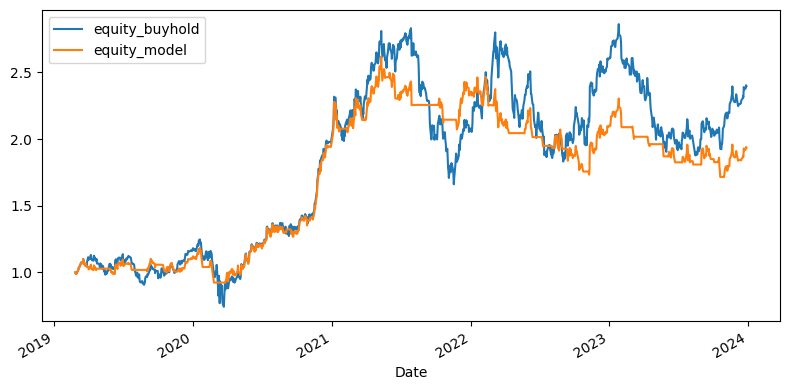

### VALE3 — CNN1D: Modelo vs Buy&Hold

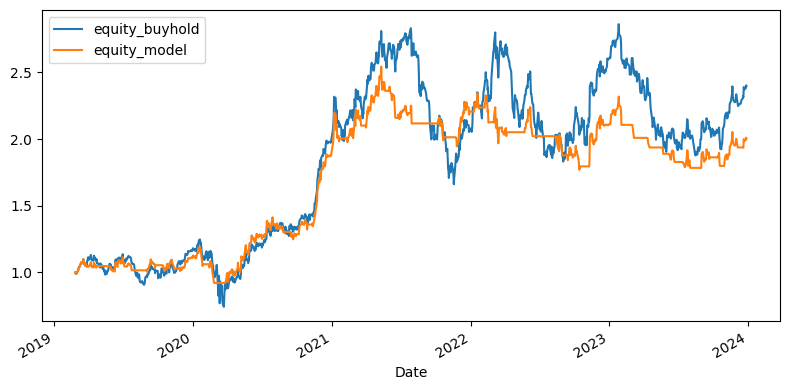

### VALE3 — LSTM: Modelo vs Buy&Hold

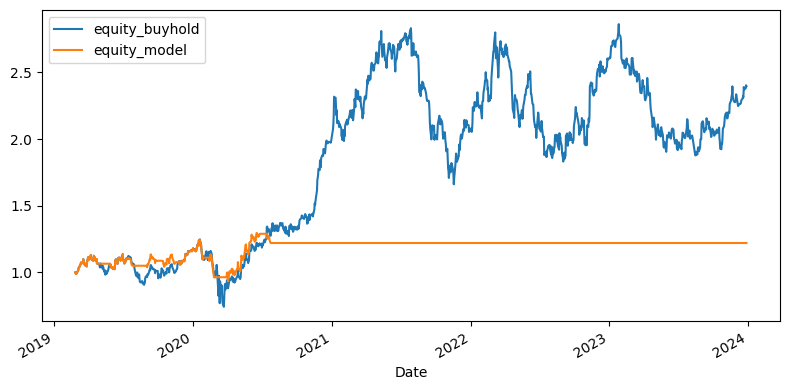

### VALE3 — CNN2D: Modelo vs Buy&Hold

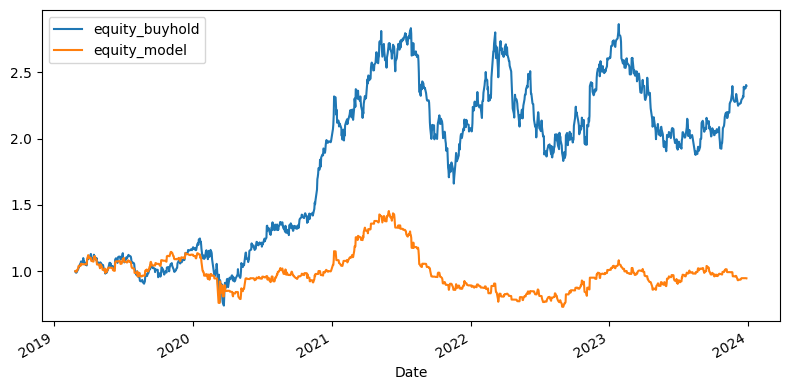

### PETR4 — MLP: Modelo vs Buy&Hold

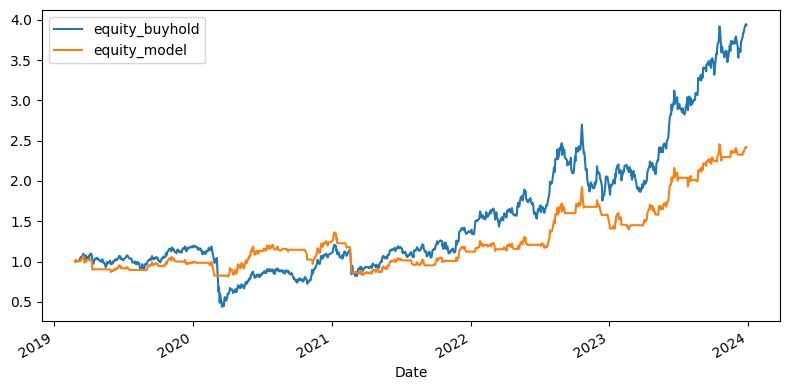

### PETR4 — CNN1D: Modelo vs Buy&Hold

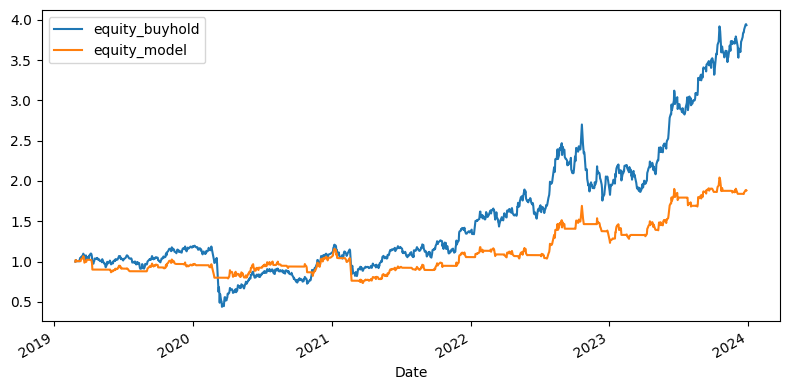

### PETR4 — LSTM: Modelo vs Buy&Hold

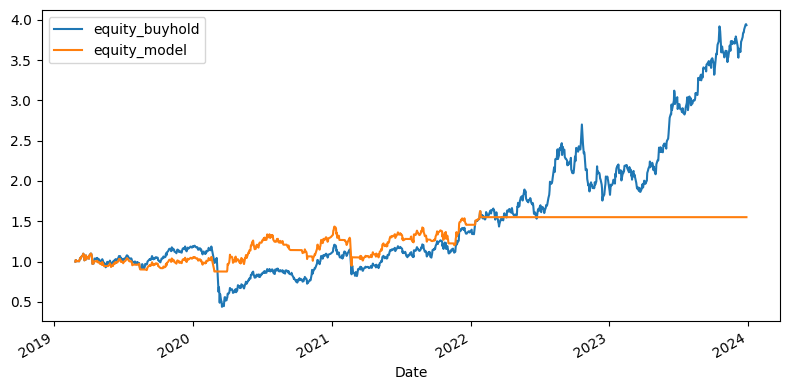

### PETR4 — CNN2D: Modelo vs Buy&Hold

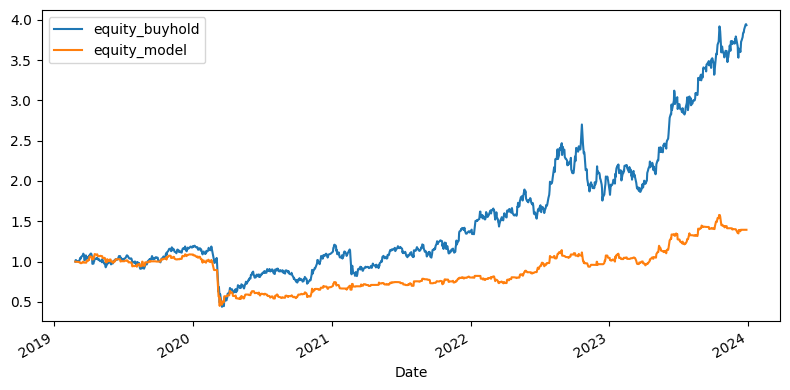

### BBAS3 — MLP: Modelo vs Buy&Hold

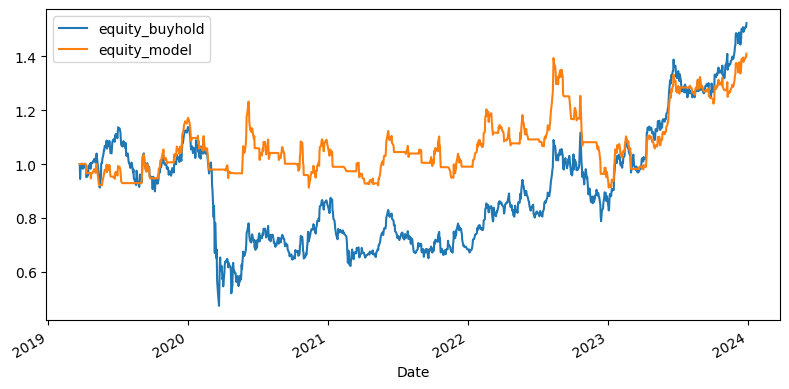

### BBAS3 — CNN1D: Modelo vs Buy&Hold

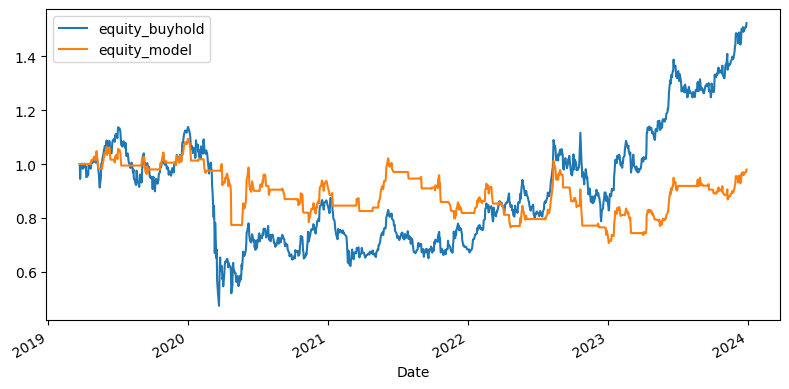

### BBAS3 — LSTM: Modelo vs Buy&Hold

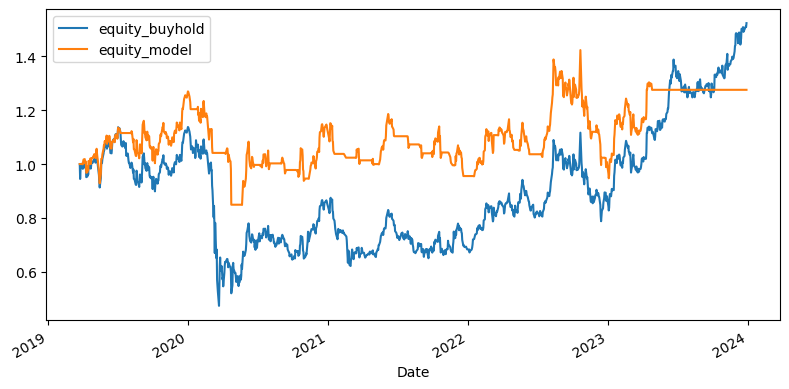

### BBAS3 — CNN2D: Modelo vs Buy&Hold

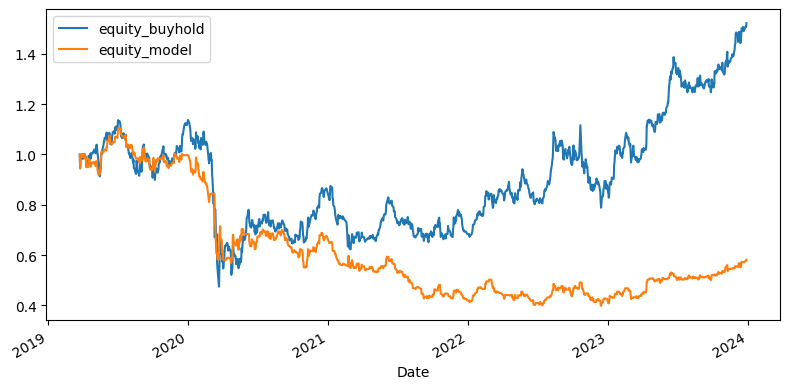

### CSNA3 — MLP: Modelo vs Buy&Hold

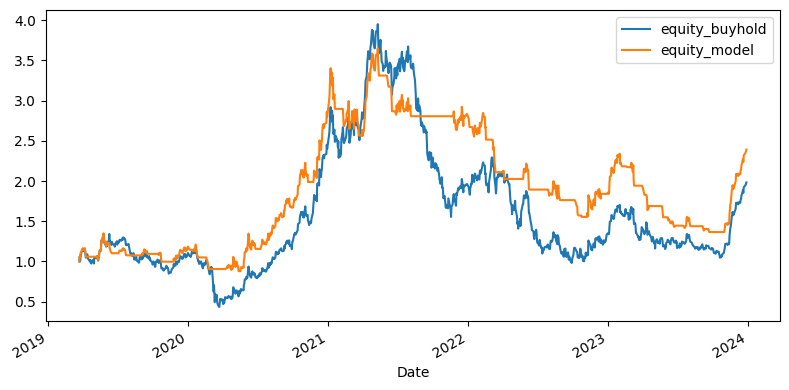

### CSNA3 — CNN1D: Modelo vs Buy&Hold

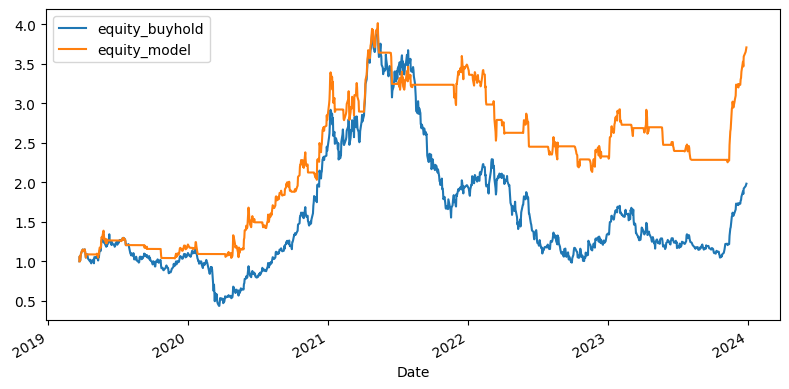

### CSNA3 — LSTM: Modelo vs Buy&Hold

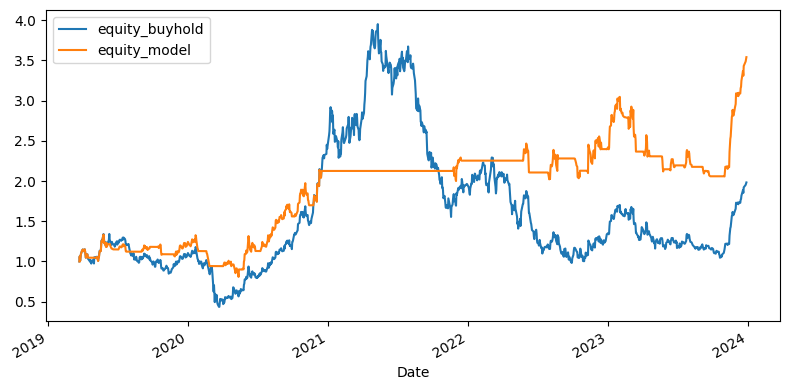

### CSNA3 — CNN2D: Modelo vs Buy&Hold

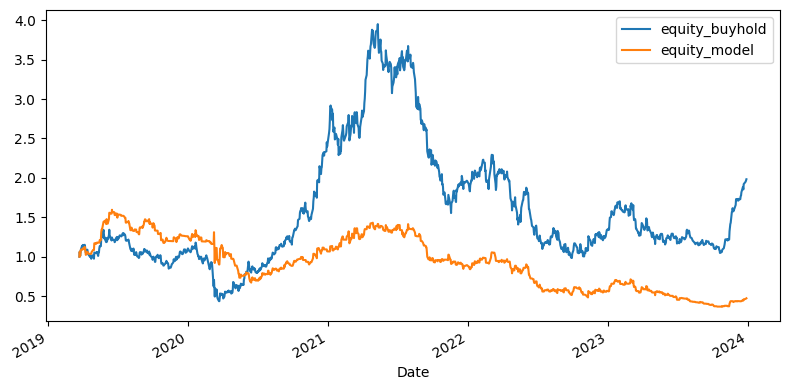

In [ ]:
# -------------------- Tabela-resumo final --------------------
summary = pd.DataFrame(rows)
# ordena por Ticker, Sharpe desc.
summary = summary.sort_values(["Ticker","Sharpe"], ascending=[True, False]).reset_index(drop=True)
display(summary)

# Melhor por Sharpe
summary_valid = summary.loc[summary["Sharpe"].notna() & np.isfinite(summary["Sharpe"])]

if summary_valid.empty:
    best_by_ticker = summary_valid.copy()
else:
    idx = summary_valid.groupby("Ticker")["Sharpe"].idxmax()
    idx = idx[~idx.isna()].astype(int)
    best_by_ticker = summary_valid.loc[idx].reset_index(drop=True)

display(best_by_ticker)


from IPython.display import display, Markdown
import matplotlib.pyplot as plt

if 'curves_dict' in globals() and len(curves_dict) > 0:
    for (ticker, model), curves in curves_dict.items():
        display(Markdown(f"### {ticker} — {model}: Modelo vs Buy&Hold"))
        ax = curves[["equity_buyhold", "equity_model"]].plot(figsize=(8,4))
        plt.tight_layout()
        plt.show()
else:
    display(Markdown("Sem curvas para exibir. Execute a célula de backtest antes."))

In [28]:
usaveis = summary.query("Sharpe >= 0.5").sort_values(["Ticker","Sharpe"], ascending=[True, False])
display(usaveis)

,Ticker,Modelo,Status,CAGR_model,CAGR_buy_hold,AnnVol,Sharpe,Sortino,MaxDrawdown,Calmar,Exposure_pct,Trades,Turnover_pa,HitRate,ProfitFactor,Expectancy_per_trade,AvgRet_per_trade,Skew,Kurtosis
4,CSNA3,CNN1D,OK,0.316807,0.154554,0.357531,0.637324,0.810128,-0.469104,0.675345,0.453626,80,16.80276,0.425000,1.932160,0.018965,0.018965,1.411966,9.015915
5,CSNA3,LSTM,OK,0.304061,0.154554,0.334554,0.627937,0.760741,-0.394124,0.771485,0.409781,60,12.60207,0.416667,2.186274,0.023819,0.023819,1.724262,12.859628


,Ticker,Melhor Modelo,CAGR Modelo,CAGR Buy&Hold,ΔCAGR,Sharpe,MDD,Calmar,Trades/ano,Exposure
0,BBAS3,MLP,7.5%,9.2%,-1.8%,-0.06,-34.5%,0.22,25,56.4%
1,CSNA3,CNN1D,31.7%,15.5%,16.2%,0.64,-46.9%,0.68,17,45.4%
2,PETR4,MLP,20.0%,32.7%,-12.7%,0.40,-39.0%,0.51,26,55.0%
3,VALE3,CNN1D,15.5%,19.8%,-4.3%,0.25,-30.4%,0.51,19,55.9%


,Modelo,Sharpe_médio,CAGR_médio,MDD_médio
0,MLP,0.232998,0.155537,-0.426383
1,CNN1D,0.164488,0.151778,-0.372923
2,LSTM,0.035381,0.123403,-0.329231
3,CNN2D,-0.347025,-0.048334,-0.624043


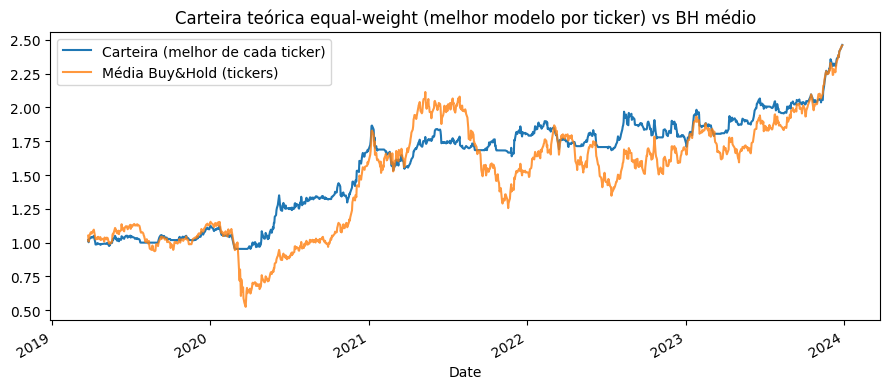

,CAGR_carteira,Sharpe_carteira,MDD_carteira
0,20.8%,1.11,-17.8%


In [ ]:
# ================= CARTEIRA TEÓRICA  =================
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# 1) Melhor modelo por ticker 
summary_ok = summary[summary["Status"]=="OK"].copy()
summary_ok = summary_ok[summary_ok["Sharpe"].notna()]
best = summary_ok.loc[summary_ok.groupby("Ticker")["Sharpe"].idxmax()].reset_index(drop=True)


def _fmt_pct(x): 
    return f"{x*100:,.1f}%" if pd.notna(x) else "NaN"

slide_rows = []
for _, r in best.iterrows():
    slide_rows.append({
        "Ticker": r["Ticker"],
        "Melhor Modelo": r["Modelo"],
        "CAGR Modelo": _fmt_pct(r["CAGR_model"]),
        "CAGR Buy&Hold": _fmt_pct(r["CAGR_buy_hold"]),
        "ΔCAGR": _fmt_pct(r["CAGR_model"] - r["CAGR_buy_hold"]),
        "Sharpe": f"{r['Sharpe']:.2f}" if pd.notna(r['Sharpe']) else "NaN",
        "MDD": _fmt_pct(r["MaxDrawdown"]),
        "Calmar": f"{r['Calmar']:.2f}" if pd.notna(r['Calmar']) else "NaN",
        "Trades/ano": f"{r['Turnover_pa']:.0f}" if pd.notna(r['Turnover_pa']) else "NaN",
        "Exposure": _fmt_pct(r["Exposure_pct"])
    })
slide_table = pd.DataFrame(slide_rows).sort_values("Ticker").reset_index(drop=True)
display(slide_table)

# 2) Ranking geral por modelo (média por modelo em todos os tickers)
rank = (
    summary_ok.groupby("Modelo")
    .agg(Sharpe_médio=("Sharpe","mean"),
         CAGR_médio=("CAGR_model","mean"),
         MDD_médio=("MaxDrawdown","mean"))
    .sort_values("Sharpe_médio", ascending=False)
    .reset_index()
)
display(rank)

# 3) Carteira teórica equal-weight (melhor de cada ticker)
eq = None
weights = {}
for _, r in best.iterrows():
    key = (r["Ticker"], r["Modelo"])
    curves = curves_dict.get(key)
    if curves is None: 
        continue
    ret = curves["ret_strategy"].rename(f"{r['Ticker']}_{r['Modelo']}")
    weights[ret.name] = 1.0 / len(best)
    eq = ret if eq is None else eq.align(ret, join="inner")[0]

rets = []
if eq is not None:
    for name in weights:
        ticker, model = name.split("_")[0], name.split("_")[1]
        r = curves_dict[(ticker, model)]["ret_strategy"].rename(name)
        rets.append(r.reindex(eq.index).fillna(0.0))

if rets:
    R = pd.concat(rets, axis=1).fillna(0.0)
    w = pd.Series(weights)
    port_ret = (R * w).sum(axis=1)
    port_equity = (1 + port_ret).cumprod()

    # métricas da carteira
    td = 252
    years = max((port_equity.index[-1] - port_equity.index[0]).days,1)/365.25
    cagr_port = port_equity.iloc[-1]**(1/years)-1
    ann_vol = port_ret.std(ddof=0)*np.sqrt(td)
    sharpe = (port_ret.mean()*td)/ann_vol if ann_vol>0 else np.nan
    cummax = port_equity.cummax()
    mdd = (port_equity/cummax - 1).min()

    # plot carteira vs média buy&hold
    plt.figure(figsize=(9,4))
    port_equity.plot(label="Carteira (melhor de cada ticker)")
    bh_list = []
    for _, r in best.iterrows():
        c = curves_dict[(r["Ticker"], r["Modelo"])]["equity_buyhold"].rename(f"BH_{r['Ticker']}")
        bh_list.append(c.reindex(port_equity.index).fillna(method="ffill").fillna(1.0))
    bh_eq = pd.concat(bh_list, axis=1).mean(axis=1)
    bh_eq.plot(label="Média Buy&Hold (tickers)", alpha=0.8)
    plt.title("Carteira teórica equal-weight (melhor modelo por ticker) vs BH médio")
    plt.legend(); plt.tight_layout()
    plt.show()

    carteira_metrics = pd.DataFrame([{
        "CAGR_carteira": _fmt_pct(cagr_port), 
        "Sharpe_carteira": f"{sharpe:.2f}" if pd.notna(sharpe) else "NaN", 
        "MDD_carteira": _fmt_pct(mdd)
    }])
    display(carteira_metrics)
else:
    print("⚠️ Não foi possível montar a carteira (verifique curves_dict/best).")
# ================= FIM =================


In [ ]:
# ================== TABELA RESUMIDA  ==================
def _fmt_pct(x): 
    return f"{x*100:,.1f}%" if pd.notna(x) else "NaN"

def _fmt_dec(x, nd=2): 
    return f"{x:.{nd}f}" if pd.notna(x) else "NaN"

summary_slide = (
    summary_ok
    .loc[:, ["Ticker","Modelo","CAGR_model","CAGR_buy_hold",
             "Sharpe","MaxDrawdown","ProfitFactor","Turnover_pa"]]
    .copy()
)


summary_slide["CAGR_model"]     = summary_slide["CAGR_model"].map(_fmt_pct)
summary_slide["CAGR_buy_hold"]  = summary_slide["CAGR_buy_hold"].map(_fmt_pct)
summary_slide["Sharpe"]         = summary_slide["Sharpe"].map(lambda x: _fmt_dec(x,2))
summary_slide["MaxDrawdown"]    = summary_slide["MaxDrawdown"].map(_fmt_pct)
summary_slide["ProfitFactor"]   = summary_slide["ProfitFactor"].map(_fmt_dec)
summary_slide["Trades/ano"]     = summary_slide["Turnover_pa"].map(lambda x: _fmt_dec(x,0))
summary_slide = summary_slide.drop(columns=["Turnover_pa"])

display(summary_slide.sort_values(["Ticker","Modelo"]).reset_index(drop=True))
# ================================================================


,Ticker,Modelo,CAGR_model,CAGR_buy_hold,Sharpe,MaxDrawdown,ProfitFactor,Trades/ano
0,BBAS3,CNN1D,-0.4%,9.2%,-0.45,-35.3%,1.06,23
1,BBAS3,CNN2D,-10.8%,9.2%,-0.67,-64.0%,0.92,120
2,BBAS3,LSTM,5.2%,9.2%,-0.12,-33.4%,1.37,12
3,BBAS3,MLP,7.5%,9.2%,-0.06,-34.5%,1.34,25
4,CSNA3,CNN1D,31.7%,15.5%,0.64,-46.9%,1.93,17
5,CSNA3,CNN2D,-14.6%,15.5%,-0.44,-77.2%,0.94,116
6,CSNA3,LSTM,30.4%,15.5%,0.63,-39.4%,2.19,13
7,CSNA3,MLP,20.1%,15.5%,0.38,-62.6%,1.48,24
8,PETR4,CNN1D,14.0%,32.7%,0.21,-36.5%,1.48,26
9,PETR4,CNN2D,7.1%,32.7%,0.05,-58.8%,1.15,119


Nosso modelo não superou consistentemente o benchmark. Apenas em CSNA3 houve ganho relevante, mas nos demais ativos ou o retorno foi menor ou o risco não compensou

Para melhorar: ajuste de threshold, incluir classe 0 (ficar de fora), incorporar custos mais realistas, ou explorar features cross-asset